In [1]:
import os, sys
from datetime import datetime
import networkx as nx
from util import adjacency_matrix_to_nei_list, dirichlet_sampling_balanced, \
    get_adjacency_matrix, generate_node_configs, generate_attack_matrix
from torchvision.datasets import MNIST
from torchvision import transforms
from local_node import local_node
import pickle

Configs

In [16]:
num_peers = 10
alpha = 100
node_list = {}
maxRound = 5
maxEpoch = 3
dataset_name = "MNIST"
topology = "ring"

In [17]:
adj_matrix = get_adjacency_matrix(topology, num_peers)
nei_list = adjacency_matrix_to_nei_list(adj_matrix)
train_dataset = None
test_dataset = None

#define the attack
attack_type = 'label flipping'
targeted = False
poisoned_node_ratio = 20
noise_injected_ratio = 20
poisoned_sample_ratio = 10
attack_matrix = generate_attack_matrix(list(range(num_peers)), attack_type, targeted, poisoned_node_ratio, noise_injected_ratio, poisoned_sample_ratio)

# dataset
if dataset_name == "MNIST":
    train_dataset = MNIST(
        f"{sys.path[0]}/data", train=True, download=True, transform=transforms.ToTensor()
    )
    test_dataset = MNIST(
        f"{sys.path[0]}/data", train=False, download=True, transform=transforms.ToTensor()
    )

# datetime object containing current date and time
now = datetime.now()
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")
experimentsName = f'{num_peers}_clients_alpha_{alpha}_{dataset_name}_{topology}_'+dt_string
targets = train_dataset.targets
client_indices = dirichlet_sampling_balanced(targets, alpha, num_peers)
cwd = os.getcwd()

experimentsName_path = cwd+'/experiments/'+experimentsName
os.mkdir(experimentsName_path)


for client in range(num_peers):
    indices = client_indices[client]
    node_id = client      
    neiList = nei_list[client]
    
    attack_info = attack_matrix[node_id]
    attack_type = attack_info['attack_type']
    targeted = attack_info['targeted']
    noise_injected_ratio = attack_info['noise_injected_ratio']
    poisoned_sample_ratio = attack_info['poisoned_sample_ratio']

    node_config = generate_node_configs(node_id, indices, experimentsName, experimentsName_path, 
                                        dataset_name, neiList, num_peers, maxRound, maxEpoch, 
                                        train_dataset, test_dataset, attack_type, targeted, 
                                        noise_injected_ratio, poisoned_sample_ratio)
    
    basic_config = node_config['basic_config']
    data_train_loader = node_config['data_train_loader']
    data_val_loader = node_config['data_val_loader']
    test_dataset_loader = node_config['test_dataset_loader']
    
    node = local_node(node_id,basic_config, data_train_loader, data_val_loader, test_dataset_loader)
    node_list[node_id] = node
    
    with open(experimentsName_path+f"/{node_id}_config.pk", "wb") as f:
        pickle.dump(node_config, f)
        f.close()
    

for round in range(maxRound):
    for node_id in node_list:
        node = node_list[node_id]
        node.curren_round = round+1
        node.local_training()
        for nei in node.neiList:
            node_list[nei].add_nei_model(round+1, node_id, node.model)
    
    for node_id in node_list:
        node = node_list[node_id]
        node.aggregation()
        

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: d:\git\beidou/experiments/10_clients_alpha_100_MNIST_ring_03_06_2024_16_51_13\node_0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_m

Epoch end: Validation, epoch number: 0
Epoch end: Validation, epoch number: 1
Epoch end: Train, epoch number: 0
Epoch end: Validation, epoch number: 2
Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Validation, epoch number: 3
Epoch end: Train, epoch number: 2
Performance of Node 0 before aggregation at round 1


d:\git\beidou\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch end: Test, epoch number: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.8929693698883057     │
│       Test/F1Score        │     0.887327253818512     │
│         Test/Loss         │     0.343293160200119     │
│      Test/Precision       │    0.8978712558746338     │
│        Test/Recall        │    0.8929693698883057     │
│    TestEpoch/Accuracy     │    0.8954479694366455     │
│     TestEpoch/F1Score     │    0.8951262831687927     │
│    TestEpoch/Precision    │    0.8978027105331421     │
│     TestEpoch/Recall      │    0.8954479694366455     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: d:\git\beidou/experiments/10_clients_alpha_100_MNIST_ring_03_06_2024_16_51_13\node_1
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_m

Epoch end: Validation, epoch number: 0
Epoch end: Validation, epoch number: 1
Epoch end: Train, epoch number: 0
Epoch end: Validation, epoch number: 2
Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Validation, epoch number: 3
Epoch end: Train, epoch number: 2
Performance of Node 1 before aggregation at round 1
Epoch end: Test, epoch number: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9050168991088867     │
│       Test/F1Score        │    0.8975604772567749     │
│         Test/Loss         │    0.28814607858657837    │
│      Test/Precision       │    0.9099013805389404     │
│        Test/Recall        │    0.9050168991088867     │
│    TestEpoch/Accuracy     │    0.9078863859176636     │
│     TestEpoch/F1Score     │     0.907087504863739     │
│    TestEpoch/Precision    │    0.9136998057365417     │
│     TestEpoch/Recall      │    0.9078863859176636     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: d:\git\beidou/experiments/10_clients_alpha_100_MNIST_ring_03_06_2024_16_51_13\node_2
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_m

Epoch end: Validation, epoch number: 0
Epoch end: Validation, epoch number: 1
Epoch end: Train, epoch number: 0
Epoch end: Validation, epoch number: 2
Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 3
Epoch end: Train, epoch number: 2
Performance of Node 2 before aggregation at round 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9201801419258118     │
│       Test/F1Score        │    0.9107360243797302     │
│         Test/Loss         │    0.26692652702331543    │
│      Test/Precision       │    0.9202078580856323     │
│        Test/Recall        │    0.9201801419258118     │
│    TestEpoch/Accuracy     │     0.917585551738739     │
│     TestEpoch/F1Score     │    0.9167702794075012     │
│    TestEpoch/Precision    │    0.9227688312530518     │
│     TestEpoch/Recall      │     0.917585551738739     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: d:\git\beidou/experiments/10_clients_alpha_100_MNIST_ring_03_06_2024_16_51_13\node_3
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_m

Epoch end: Validation, epoch number: 0
Epoch end: Validation, epoch number: 1
Epoch end: Train, epoch number: 0
Epoch end: Validation, epoch number: 2
Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 3
Epoch end: Train, epoch number: 2
Performance of Node 3 before aggregation at round 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9093675017356873     │
│       Test/F1Score        │    0.9013852477073669     │
│         Test/Loss         │    0.3178766369819641     │
│      Test/Precision       │    0.9105818867683411     │
│        Test/Recall        │    0.9093675017356873     │
│    TestEpoch/Accuracy     │    0.9088906645774841     │
│     TestEpoch/F1Score     │    0.9053278565406799     │
│    TestEpoch/Precision    │    0.9044275283813477     │
│     TestEpoch/Recall      │    0.9088906645774841     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: d:\git\beidou/experiments/10_clients_alpha_100_MNIST_ring_03_06_2024_16_51_13\node_4
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_m

Epoch end: Validation, epoch number: 0
Epoch end: Validation, epoch number: 1
Epoch end: Train, epoch number: 0
Epoch end: Validation, epoch number: 2
Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 3
Epoch end: Train, epoch number: 2
Performance of Node 4 before aggregation at round 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.8968166708946228     │
│       Test/F1Score        │    0.8885594606399536     │
│         Test/Loss         │    0.32001349329948425    │
│      Test/Precision       │    0.9065088629722595     │
│        Test/Recall        │    0.8968166708946228     │
│    TestEpoch/Accuracy     │    0.8990492224693298     │
│     TestEpoch/F1Score     │    0.8987903594970703     │
│    TestEpoch/Precision    │    0.9061890840530396     │
│     TestEpoch/Recall      │    0.8990492224693298     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: d:\git\beidou/experiments/10_clients_alpha_100_MNIST_ring_03_06_2024_16_51_13\node_5
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_m

Epoch end: Validation, epoch number: 0
Epoch end: Validation, epoch number: 1
Epoch end: Train, epoch number: 0
Epoch end: Validation, epoch number: 2
Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 3
Epoch end: Train, epoch number: 2
Performance of Node 5 before aggregation at round 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9048920273780823     │
│       Test/F1Score        │    0.8966192603111267     │
│         Test/Loss         │    0.3148370683193207     │
│      Test/Precision       │    0.9043259024620056     │
│        Test/Recall        │    0.9048920273780823     │
│    TestEpoch/Accuracy     │    0.9008111357688904     │
│     TestEpoch/F1Score     │    0.9015026688575745     │
│    TestEpoch/Precision    │    0.9048023223876953     │
│     TestEpoch/Recall      │    0.9008111357688904     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: d:\git\beidou/experiments/10_clients_alpha_100_MNIST_ring_03_06_2024_16_51_13\node_6
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_m

Epoch end: Validation, epoch number: 0
Epoch end: Validation, epoch number: 1
Epoch end: Train, epoch number: 0
Epoch end: Validation, epoch number: 2
Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch end: Validation, epoch number: 3
Epoch end: Train, epoch number: 2


You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Performance of Node 6 before aggregation at round 1
Epoch end: Test, epoch number: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.888119637966156     │
│       Test/F1Score        │     0.884058952331543     │
│         Test/Loss         │    0.33572250604629517    │
│      Test/Precision       │    0.9016454219818115     │
│        Test/Recall        │     0.888119637966156     │
│    TestEpoch/Accuracy     │    0.8908218741416931     │
│     TestEpoch/F1Score     │    0.8904913067817688     │
│    TestEpoch/Precision    │    0.8952890634536743     │
│     TestEpoch/Recall      │    0.8908218741416931     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: d:\git\beidou/experiments/10_clients_alpha_100_MNIST_ring_03_06_2024_16_51_13\node_7
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_m

Epoch end: Validation, epoch number: 0
Epoch end: Validation, epoch number: 1
Epoch end: Train, epoch number: 0
Epoch end: Validation, epoch number: 2
Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 3
Epoch end: Train, epoch number: 2
Performance of Node 7 before aggregation at round 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9031873941421509     │
│       Test/F1Score        │    0.8942229747772217     │
│         Test/Loss         │    0.3148594796657562     │
│      Test/Precision       │    0.9090022444725037     │
│        Test/Recall        │    0.9031873941421509     │
│    TestEpoch/Accuracy     │     0.903684139251709     │
│     TestEpoch/F1Score     │    0.9037006497383118     │
│    TestEpoch/Precision    │    0.9086053371429443     │
│     TestEpoch/Recall      │     0.903684139251709     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: d:\git\beidou/experiments/10_clients_alpha_100_MNIST_ring_03_06_2024_16_51_13\node_8
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_m

Epoch end: Validation, epoch number: 0
Epoch end: Validation, epoch number: 1
Epoch end: Train, epoch number: 0
Epoch end: Validation, epoch number: 2
Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Validation, epoch number: 3
Epoch end: Train, epoch number: 2
Performance of Node 8 before aggregation at round 1
Epoch end: Test, epoch number: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9072490334510803     │
│       Test/F1Score        │     0.900213360786438     │
│         Test/Loss         │    0.3333318531513214     │
│      Test/Precision       │    0.9176552295684814     │
│        Test/Recall        │    0.9072490334510803     │
│    TestEpoch/Accuracy     │    0.9067181944847107     │
│     TestEpoch/F1Score     │    0.9051389098167419     │
│    TestEpoch/Precision    │    0.9079087376594543     │
│     TestEpoch/Recall      │    0.9067181944847107     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: d:\git\beidou/experiments/10_clients_alpha_100_MNIST_ring_03_06_2024_16_51_13\node_9
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_m

Epoch end: Validation, epoch number: 0
Epoch end: Validation, epoch number: 1
Epoch end: Train, epoch number: 0
Epoch end: Validation, epoch number: 2
Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Validation, epoch number: 3
Epoch end: Train, epoch number: 2
Performance of Node 9 before aggregation at round 1
Epoch end: Test, epoch number: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9065403342247009     │
│       Test/F1Score        │    0.8950178027153015     │
│         Test/Loss         │    0.3073243498802185     │
│      Test/Precision       │    0.9117442965507507     │
│        Test/Recall        │    0.9065403342247009     │
│    TestEpoch/Accuracy     │    0.9002997875213623     │
│     TestEpoch/F1Score     │    0.8997836112976074     │
│    TestEpoch/Precision    │    0.9065050482749939     │
│     TestEpoch/Recall      │    0.9002997875213623     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 0 aggregate model with [1, 9]
Performance of Node 0 after aggregation at round 1


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.457844078540802     │
│       Test/F1Score        │    0.4094978868961334     │
│         Test/Loss         │    1.6528276205062866     │
│      Test/Precision       │     0.565353274345398     │
│        Test/Recall        │     0.457844078540802     │
│    TestEpoch/Accuracy     │    0.4623481333255768     │
│     TestEpoch/F1Score     │    0.43500077724456787    │
│    TestEpoch/Precision    │    0.6706679463386536     │
│     TestEpoch/Recall      │    0.4623481333255768     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 1 aggregate model with [0, 2]
Performance of Node 1 after aggregation at round 1


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.3723289370536804     │
│       Test/F1Score        │    0.2982305884361267     │
│         Test/Loss         │    1.6354472637176514     │
│      Test/Precision       │    0.3927122950553894     │
│        Test/Recall        │    0.3723289370536804     │
│    TestEpoch/Accuracy     │    0.37240761518478394    │
│     TestEpoch/F1Score     │    0.3098907470703125     │
│    TestEpoch/Precision    │    0.5906047821044922     │
│     TestEpoch/Recall      │    0.37240761518478394    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 2 aggregate model with [1, 3]
Performance of Node 2 after aggregation at round 1


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.6010212898254395     │
│       Test/F1Score        │    0.5559419989585876     │
│         Test/Loss         │    1.5015228986740112     │
│      Test/Precision       │    0.6253727674484253     │
│        Test/Recall        │    0.6010212898254395     │
│    TestEpoch/Accuracy     │    0.6032313108444214     │
│     TestEpoch/F1Score     │     0.573030948638916     │
│    TestEpoch/Precision    │    0.7296676635742188     │
│     TestEpoch/Recall      │    0.6032313108444214     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 3 aggregate model with [2, 4]
Performance of Node 3 after aggregation at round 1


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5945310592651367     │
│       Test/F1Score        │    0.5494806170463562     │
│         Test/Loss         │    1.5946890115737915     │
│      Test/Precision       │    0.6322588920593262     │
│        Test/Recall        │    0.5945310592651367     │
│    TestEpoch/Accuracy     │    0.5918933153152466     │
│     TestEpoch/F1Score     │    0.5567405223846436     │
│    TestEpoch/Precision    │    0.6317833065986633     │
│     TestEpoch/Recall      │    0.5918933153152466     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 4 aggregate model with [3, 5]
Performance of Node 4 after aggregation at round 1


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.6112698912620544     │
│       Test/F1Score        │    0.5597809553146362     │
│         Test/Loss         │     1.627658486366272     │
│      Test/Precision       │    0.6487171649932861     │
│        Test/Recall        │    0.6112698912620544     │
│    TestEpoch/Accuracy     │     0.62093186378479      │
│     TestEpoch/F1Score     │    0.5822835564613342     │
│    TestEpoch/Precision    │    0.6581063270568848     │
│     TestEpoch/Recall      │     0.62093186378479      │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 5 aggregate model with [4, 6]
Performance of Node 5 after aggregation at round 1


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.3709906041622162     │
│       Test/F1Score        │    0.2822869122028351     │
│         Test/Loss         │    1.6720538139343262     │
│      Test/Precision       │    0.36935827136039734    │
│        Test/Recall        │    0.3709906041622162     │
│    TestEpoch/Accuracy     │    0.3702612519264221     │
│     TestEpoch/F1Score     │    0.30106258392333984    │
│    TestEpoch/Precision    │    0.6067913770675659     │
│     TestEpoch/Recall      │    0.3702612519264221     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 6 aggregate model with [5, 7]
Performance of Node 6 after aggregation at round 1


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.36340194940567017    │
│       Test/F1Score        │     0.300326943397522     │
│         Test/Loss         │    1.6556893587112427     │
│      Test/Precision       │    0.3787749409675598     │
│        Test/Recall        │    0.36340194940567017    │
│    TestEpoch/Accuracy     │    0.3700755536556244     │
│     TestEpoch/F1Score     │    0.31585264205932617    │
│    TestEpoch/Precision    │    0.5535891056060791     │
│     TestEpoch/Recall      │    0.3700755536556244     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 7 aggregate model with [6, 8]
Performance of Node 7 after aggregation at round 1


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.6637017726898193     │
│       Test/F1Score        │    0.6161407828330994     │
│         Test/Loss         │     1.490371584892273     │
│      Test/Precision       │    0.6955996751785278     │
│        Test/Recall        │    0.6637017726898193     │
│    TestEpoch/Accuracy     │    0.6644071340560913     │
│     TestEpoch/F1Score     │    0.6323056817054749     │
│    TestEpoch/Precision    │    0.7074785232543945     │
│     TestEpoch/Recall      │    0.6644071340560913     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 8 aggregate model with [7, 9]
Performance of Node 8 after aggregation at round 1


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5627517700195312     │
│       Test/F1Score        │    0.5212018489837646     │
│         Test/Loss         │    1.6381492614746094     │
│      Test/Precision       │     0.630868136882782     │
│        Test/Recall        │    0.5627517700195312     │
│    TestEpoch/Accuracy     │    0.5596657395362854     │
│     TestEpoch/F1Score     │    0.5387648940086365     │
│    TestEpoch/Precision    │    0.6388947367668152     │
│     TestEpoch/Recall      │    0.5596657395362854     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 9 aggregate model with [0, 8]
Performance of Node 9 after aggregation at round 1


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.455629825592041     │
│       Test/F1Score        │    0.41098636388778687    │
│         Test/Loss         │    1.6831493377685547     │
│      Test/Precision       │    0.5029821395874023     │
│        Test/Recall        │     0.455629825592041     │
│    TestEpoch/Accuracy     │    0.4603094458580017     │
│     TestEpoch/F1Score     │    0.42986205220222473    │
│    TestEpoch/Precision    │    0.5905460119247437     │
│     TestEpoch/Recall      │    0.4603094458580017     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
d:\git\beidou\venv\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory d:\git\beidou/experiments/10_clients_alpha_100_MNIST_ring_03_06_2024_16_51_13\node_0\version_0\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-------------------------

Epoch end: Validation, epoch number: 0
Epoch end: Validation, epoch number: 1
Epoch end: Train, epoch number: 0
Epoch end: Validation, epoch number: 2
Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 3
Epoch end: Train, epoch number: 2
Performance of Node 0 before aggregation at round 2


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.8996607661247253     │
│       Test/F1Score        │    0.8940332531929016     │
│         Test/Loss         │    0.33253857493400574    │
│      Test/Precision       │    0.9042016863822937     │
│        Test/Recall        │    0.8996607661247253     │
│    TestEpoch/Accuracy     │     0.902703046798706     │
│     TestEpoch/F1Score     │    0.9025099277496338     │
│    TestEpoch/Precision    │    0.9055227041244507     │
│     TestEpoch/Recall      │     0.902703046798706     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
d:\git\beidou\venv\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory d:\git\beidou/experiments/10_clients_alpha_100_MNIST_ring_03_06_2024_16_51_13\node_1\version_0\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-------------------------

Epoch end: Validation, epoch number: 0
Epoch end: Validation, epoch number: 1
Epoch end: Train, epoch number: 0
Epoch end: Validation, epoch number: 2
Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 3
Epoch end: Train, epoch number: 2
Performance of Node 1 before aggregation at round 2


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.907427191734314     │
│       Test/F1Score        │    0.9003332853317261     │
│         Test/Loss         │    0.26317375898361206    │
│      Test/Precision       │    0.9130131006240845     │
│        Test/Recall        │     0.907427191734314     │
│    TestEpoch/Accuracy     │    0.9065600037574768     │
│     TestEpoch/F1Score     │    0.9059292674064636     │
│    TestEpoch/Precision    │    0.9105584621429443     │
│     TestEpoch/Recall      │    0.9065600037574768     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
d:\git\beidou\venv\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory d:\git\beidou/experiments/10_clients_alpha_100_MNIST_ring_03_06_2024_16_51_13\node_2\version_0\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-------------------------

Epoch end: Validation, epoch number: 0
Epoch end: Validation, epoch number: 1
Epoch end: Train, epoch number: 0
Epoch end: Validation, epoch number: 2
Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 3
Epoch end: Train, epoch number: 2
Performance of Node 2 before aggregation at round 2


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9163786172866821     │
│       Test/F1Score        │    0.9066253304481506     │
│         Test/Loss         │    0.29763150215148926    │
│      Test/Precision       │    0.9178948402404785     │
│        Test/Recall        │    0.9163786172866821     │
│    TestEpoch/Accuracy     │    0.9150047898292542     │
│     TestEpoch/F1Score     │    0.9132691621780396     │
│    TestEpoch/Precision    │    0.9173524379730225     │
│     TestEpoch/Recall      │    0.9150047898292542     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
d:\git\beidou\venv\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory d:\git\beidou/experiments/10_clients_alpha_100_MNIST_ring_03_06_2024_16_51_13\node_3\version_0\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-------------------------

Epoch end: Validation, epoch number: 0
Epoch end: Validation, epoch number: 1
Epoch end: Train, epoch number: 0
Epoch end: Validation, epoch number: 2
Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 3
Epoch end: Train, epoch number: 2
Performance of Node 3 before aggregation at round 2


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9095633625984192     │
│       Test/F1Score        │    0.9037621021270752     │
│         Test/Loss         │    0.27923330664634705    │
│      Test/Precision       │    0.9133910536766052     │
│        Test/Recall        │    0.9095633625984192     │
│    TestEpoch/Accuracy     │    0.9140070676803589     │
│     TestEpoch/F1Score     │    0.9144172668457031     │
│    TestEpoch/Precision    │    0.9163655638694763     │
│     TestEpoch/Recall      │    0.9140070676803589     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
d:\git\beidou\venv\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory d:\git\beidou/experiments/10_clients_alpha_100_MNIST_ring_03_06_2024_16_51_13\node_4\version_0\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-------------------------

Epoch end: Validation, epoch number: 0
Epoch end: Validation, epoch number: 1
Epoch end: Train, epoch number: 0
Epoch end: Validation, epoch number: 2
Epoch end: Train, epoch number: 1
Epoch end: Validation, epoch number: 3
Epoch end: Train, epoch number: 2


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Performance of Node 4 before aggregation at round 2
Epoch end: Test, epoch number: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9113373756408691     │
│       Test/F1Score        │    0.9035955667495728     │
│         Test/Loss         │    0.29587841033935547    │
│      Test/Precision       │    0.9163749814033508     │
│        Test/Recall        │    0.9113373756408691     │
│    TestEpoch/Accuracy     │    0.9130653142929077     │
│     TestEpoch/F1Score     │     0.913404107093811     │
│    TestEpoch/Precision    │    0.9178717732429504     │
│     TestEpoch/Recall      │    0.9130653142929077     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
d:\git\beidou\venv\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory d:\git\beidou/experiments/10_clients_alpha_100_MNIST_ring_03_06_2024_16_51_13\node_5\version_0\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-------------------------

Epoch end: Validation, epoch number: 0
Epoch end: Validation, epoch number: 1
Epoch end: Train, epoch number: 0
Epoch end: Validation, epoch number: 2
Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 3
Epoch end: Train, epoch number: 2
Performance of Node 5 before aggregation at round 2


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9145429134368896     │
│       Test/F1Score        │    0.9013848304748535     │
│         Test/Loss         │    0.32814517617225647    │
│      Test/Precision       │    0.9086794257164001     │
│        Test/Recall        │    0.9145429134368896     │
│    TestEpoch/Accuracy     │    0.9069566130638123     │
│     TestEpoch/F1Score     │     0.905272364616394     │
│    TestEpoch/Precision    │    0.9069477915763855     │
│     TestEpoch/Recall      │    0.9069566130638123     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
d:\git\beidou\venv\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory d:\git\beidou/experiments/10_clients_alpha_100_MNIST_ring_03_06_2024_16_51_13\node_6\version_0\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-------------------------

Epoch end: Validation, epoch number: 0
Epoch end: Validation, epoch number: 1
Epoch end: Train, epoch number: 0
Epoch end: Validation, epoch number: 2
Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 3
Epoch end: Train, epoch number: 2
Performance of Node 6 before aggregation at round 2


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.8912848830223083     │
│       Test/F1Score        │    0.8843196034431458     │
│         Test/Loss         │    0.3522847294807434     │
│      Test/Precision       │    0.9011589288711548     │
│        Test/Recall        │    0.8912848830223083     │
│    TestEpoch/Accuracy     │    0.8957952260971069     │
│     TestEpoch/F1Score     │    0.8952980041503906     │
│    TestEpoch/Precision    │    0.9019641280174255     │
│     TestEpoch/Recall      │    0.8957952260971069     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
d:\git\beidou\venv\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory d:\git\beidou/experiments/10_clients_alpha_100_MNIST_ring_03_06_2024_16_51_13\node_7\version_0\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-------------------------

Epoch end: Validation, epoch number: 0
Epoch end: Validation, epoch number: 1
Epoch end: Train, epoch number: 0
Epoch end: Validation, epoch number: 2
Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 3
Epoch end: Train, epoch number: 2
Performance of Node 7 before aggregation at round 2


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9178974628448486     │
│       Test/F1Score        │    0.9120577573776245     │
│         Test/Loss         │    0.29420801997184753    │
│      Test/Precision       │    0.9268904328346252     │
│        Test/Recall        │    0.9178974628448486     │
│    TestEpoch/Accuracy     │    0.9196301102638245     │
│     TestEpoch/F1Score     │    0.9198357462882996     │
│    TestEpoch/Precision    │    0.9231463670730591     │
│     TestEpoch/Recall      │    0.9196301102638245     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
d:\git\beidou\venv\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory d:\git\beidou/experiments/10_clients_alpha_100_MNIST_ring_03_06_2024_16_51_13\node_8\version_0\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-------------------------

Epoch end: Validation, epoch number: 0
Epoch end: Validation, epoch number: 1
Epoch end: Train, epoch number: 0
Epoch end: Validation, epoch number: 2
Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 3
Epoch end: Train, epoch number: 2
Performance of Node 8 before aggregation at round 2


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9131616950035095     │
│       Test/F1Score        │    0.9052514433860779     │
│         Test/Loss         │    0.3217445909976959     │
│      Test/Precision       │    0.9149127006530762     │
│        Test/Recall        │    0.9131616950035095     │
│    TestEpoch/Accuracy     │    0.9144800901412964     │
│     TestEpoch/F1Score     │    0.9133988618850708     │
│    TestEpoch/Precision    │    0.9141767024993896     │
│     TestEpoch/Recall      │    0.9144800901412964     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
d:\git\beidou\venv\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory d:\git\beidou/experiments/10_clients_alpha_100_MNIST_ring_03_06_2024_16_51_13\node_9\version_0\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-------------------------

Epoch end: Validation, epoch number: 0
Epoch end: Validation, epoch number: 1
Epoch end: Train, epoch number: 0
Epoch end: Validation, epoch number: 2
Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 3
Epoch end: Train, epoch number: 2
Performance of Node 9 before aggregation at round 2


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9044797420501709     │
│       Test/F1Score        │    0.8933593034744263     │
│         Test/Loss         │     0.326854944229126     │
│      Test/Precision       │    0.9080813527107239     │
│        Test/Recall        │    0.9044797420501709     │
│    TestEpoch/Accuracy     │    0.8972874879837036     │
│     TestEpoch/F1Score     │    0.8978546857833862     │
│    TestEpoch/Precision    │    0.9064900875091553     │
│     TestEpoch/Recall      │    0.8972874879837036     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 0 aggregate model with [1, 9]
Performance of Node 0 after aggregation at round 2


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 2


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.8756067752838135     │
│       Test/F1Score        │    0.8672246336936951     │
│         Test/Loss         │     0.476867139339447     │
│      Test/Precision       │    0.8791015148162842     │
│        Test/Recall        │    0.8756067752838135     │
│    TestEpoch/Accuracy     │    0.8788397312164307     │
│     TestEpoch/F1Score     │    0.8791080713272095     │
│    TestEpoch/Precision    │    0.8833514451980591     │
│     TestEpoch/Recall      │    0.8788397312164307     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 1 aggregate model with [0, 2]
Performance of Node 1 after aggregation at round 2


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 2


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9080691337585449     │
│       Test/F1Score        │    0.9010494947433472     │
│         Test/Loss         │    0.45308226346969604    │
│      Test/Precision       │     0.91307532787323      │
│        Test/Recall        │    0.9080691337585449     │
│    TestEpoch/Accuracy     │    0.9105339646339417     │
│     TestEpoch/F1Score     │    0.9102368354797363     │
│    TestEpoch/Precision    │    0.9145026803016663     │
│     TestEpoch/Recall      │    0.9105339646339417     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 2 aggregate model with [1, 3]
Performance of Node 2 after aggregation at round 2


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 2


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9374653100967407     │
│       Test/F1Score        │    0.9332942366600037     │
│         Test/Loss         │    0.39563679695129395    │
│      Test/Precision       │    0.9410114288330078     │
│        Test/Recall        │    0.9374653100967407     │
│    TestEpoch/Accuracy     │    0.9340011477470398     │
│     TestEpoch/F1Score     │    0.9334740042686462     │
│    TestEpoch/Precision    │    0.9342665076255798     │
│     TestEpoch/Recall      │    0.9340011477470398     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 3 aggregate model with [2, 4]
Performance of Node 3 after aggregation at round 2


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 2


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9093636870384216     │
│       Test/F1Score        │    0.9018904566764832     │
│         Test/Loss         │    0.4276232123374939     │
│      Test/Precision       │    0.9100021123886108     │
│        Test/Recall        │    0.9093636870384216     │
│    TestEpoch/Accuracy     │    0.9075644016265869     │
│     TestEpoch/F1Score     │    0.9079710841178894     │
│    TestEpoch/Precision    │    0.9099249243736267     │
│     TestEpoch/Recall      │    0.9075644016265869     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 4 aggregate model with [3, 5]
Performance of Node 4 after aggregation at round 2


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 2


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9072383642196655     │
│       Test/F1Score        │    0.8985809683799744     │
│         Test/Loss         │    0.42677274346351624    │
│      Test/Precision       │    0.9082757234573364     │
│        Test/Recall        │    0.9072383642196655     │
│    TestEpoch/Accuracy     │    0.9096561670303345     │
│     TestEpoch/F1Score     │    0.9097545146942139     │
│    TestEpoch/Precision    │    0.9122755527496338     │
│     TestEpoch/Recall      │    0.9096561670303345     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 5 aggregate model with [4, 6]
Performance of Node 5 after aggregation at round 2


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 2


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9120489358901978     │
│       Test/F1Score        │    0.9005662798881531     │
│         Test/Loss         │    0.4773428738117218     │
│      Test/Precision       │    0.9111228585243225     │
│        Test/Recall        │    0.9120489358901978     │
│    TestEpoch/Accuracy     │     0.905278205871582     │
│     TestEpoch/F1Score     │    0.9041025042533875     │
│    TestEpoch/Precision    │    0.9072452783584595     │
│     TestEpoch/Recall      │     0.905278205871582     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 6 aggregate model with [5, 7]
Performance of Node 6 after aggregation at round 2


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 2


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.8975411057472229     │
│       Test/F1Score        │    0.8915060758590698     │
│         Test/Loss         │    0.47406524419784546    │
│      Test/Precision       │    0.9050601124763489     │
│        Test/Recall        │    0.8975411057472229     │
│    TestEpoch/Accuracy     │    0.9019356966018677     │
│     TestEpoch/F1Score     │    0.9019389748573303     │
│    TestEpoch/Precision    │     0.907339334487915     │
│     TestEpoch/Recall      │    0.9019356966018677     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 7 aggregate model with [6, 8]
Performance of Node 7 after aggregation at round 2


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 2


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9152004718780518     │
│       Test/F1Score        │     0.908815324306488     │
│         Test/Loss         │    0.41603854298591614    │
│      Test/Precision       │    0.9246490597724915     │
│        Test/Recall        │    0.9152004718780518     │
│    TestEpoch/Accuracy     │    0.9162992238998413     │
│     TestEpoch/F1Score     │    0.9162888526916504     │
│    TestEpoch/Precision    │    0.9187239408493042     │
│     TestEpoch/Recall      │    0.9162992238998413     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 8 aggregate model with [7, 9]
Performance of Node 8 after aggregation at round 2


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 2


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.8933666944503784     │
│       Test/F1Score        │    0.8834823369979858     │
│         Test/Loss         │    0.5031745433807373     │
│      Test/Precision       │    0.8989760875701904     │
│        Test/Recall        │    0.8933666944503784     │
│    TestEpoch/Accuracy     │    0.8897699117660522     │
│     TestEpoch/F1Score     │    0.8896962404251099     │
│    TestEpoch/Precision    │    0.8964027762413025     │
│     TestEpoch/Recall      │    0.8897699117660522     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 9 aggregate model with [0, 8]
Performance of Node 9 after aggregation at round 2


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 2


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.8847569227218628     │
│       Test/F1Score        │    0.8734005093574524     │
│         Test/Loss         │    0.5363358855247498     │
│      Test/Precision       │    0.8918277025222778     │
│        Test/Recall        │    0.8847569227218628     │
│    TestEpoch/Accuracy     │    0.8784034848213196     │
│     TestEpoch/F1Score     │    0.8787559270858765     │
│    TestEpoch/Precision    │    0.8946932554244995     │
│     TestEpoch/Recall      │    0.8784034848213196     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_metrics  | MetricCollection          | 0      | ?        | ?        
3 | cm            | MulticlassConfusionM

Epoch end: Validation, epoch number: 4
Epoch end: Validation, epoch number: 5
Epoch end: Train, epoch number: 3
Epoch end: Validation, epoch number: 6
Epoch end: Train, epoch number: 4


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 7
Epoch end: Train, epoch number: 5
Performance of Node 0 before aggregation at round 3


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 3


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9081861972808838     │
│       Test/F1Score        │    0.9024963974952698     │
│         Test/Loss         │    0.26842620968818665    │
│      Test/Precision       │     0.910161018371582     │
│        Test/Recall        │    0.9081861972808838     │
│    TestEpoch/Accuracy     │    0.9123691320419312     │
│     TestEpoch/F1Score     │    0.9125930070877075     │
│    TestEpoch/Precision    │    0.9140495657920837     │
│     TestEpoch/Recall      │    0.9123691320419312     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_metrics  | MetricCollection          | 0      | ?        | ?        
3 | cm            | MulticlassConfusionM

Epoch end: Validation, epoch number: 4
Epoch end: Validation, epoch number: 5
Epoch end: Train, epoch number: 3
Epoch end: Validation, epoch number: 6
Epoch end: Train, epoch number: 4


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 7
Epoch end: Train, epoch number: 5
Performance of Node 1 before aggregation at round 3


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 3


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9039320945739746     │
│       Test/F1Score        │    0.8929052352905273     │
│         Test/Loss         │    0.2707725763320923     │
│      Test/Precision       │    0.9043985605239868     │
│        Test/Recall        │    0.9039320945739746     │
│    TestEpoch/Accuracy     │    0.9059780240058899     │
│     TestEpoch/F1Score     │    0.9052712917327881     │
│    TestEpoch/Precision    │     0.913913369178772     │
│     TestEpoch/Recall      │    0.9059780240058899     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_metrics  | MetricCollection          | 0      | ?        | ?        
3 | cm            | MulticlassConfusionM

Epoch end: Validation, epoch number: 4
Epoch end: Validation, epoch number: 5
Epoch end: Train, epoch number: 3
Epoch end: Validation, epoch number: 6
Epoch end: Train, epoch number: 4


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 7
Epoch end: Train, epoch number: 5
Performance of Node 2 before aggregation at round 3


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 3


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9279407262802124     │
│       Test/F1Score        │    0.9226546883583069     │
│         Test/Loss         │    0.22572533786296844    │
│      Test/Precision       │    0.9348124265670776     │
│        Test/Recall        │    0.9279407262802124     │
│    TestEpoch/Accuracy     │    0.9277930855751038     │
│     TestEpoch/F1Score     │    0.9265977740287781     │
│    TestEpoch/Precision    │    0.9315416812896729     │
│     TestEpoch/Recall      │    0.9277930855751038     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_metrics  | MetricCollection          | 0      | ?        | ?        
3 | cm            | MulticlassConfusionM

Epoch end: Validation, epoch number: 4
Epoch end: Validation, epoch number: 5
Epoch end: Train, epoch number: 3
Epoch end: Validation, epoch number: 6
Epoch end: Train, epoch number: 4


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Validation, epoch number: 7
Epoch end: Train, epoch number: 5
Performance of Node 3 before aggregation at round 3
Epoch end: Test, epoch number: 3


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9351400136947632     │
│       Test/F1Score        │     0.92961186170578      │
│         Test/Loss         │    0.22202280163764954    │
│      Test/Precision       │    0.9351328611373901     │
│        Test/Recall        │    0.9351400136947632     │
│    TestEpoch/Accuracy     │    0.9336808919906616     │
│     TestEpoch/F1Score     │    0.9322623610496521     │
│    TestEpoch/Precision    │     0.931657075881958     │
│     TestEpoch/Recall      │    0.9336808919906616     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_metrics  | MetricCollection          | 0      | ?        | ?        
3 | cm            | MulticlassConfusionM

Epoch end: Validation, epoch number: 4
Epoch end: Validation, epoch number: 5
Epoch end: Train, epoch number: 3
Epoch end: Validation, epoch number: 6
Epoch end: Train, epoch number: 4


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 7
Epoch end: Train, epoch number: 5
Performance of Node 4 before aggregation at round 3


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 3


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9179651141166687     │
│       Test/F1Score        │    0.9118503928184509     │
│         Test/Loss         │    0.26891690492630005    │
│      Test/Precision       │    0.9209688901901245     │
│        Test/Recall        │    0.9179651141166687     │
│    TestEpoch/Accuracy     │    0.9222968816757202     │
│     TestEpoch/F1Score     │    0.9226029515266418     │
│    TestEpoch/Precision    │    0.9250009059906006     │
│     TestEpoch/Recall      │    0.9222968816757202     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_metrics  | MetricCollection          | 0      | ?        | ?        
3 | cm            | MulticlassConfusionM

Epoch end: Validation, epoch number: 4
Epoch end: Validation, epoch number: 5
Epoch end: Train, epoch number: 3
Epoch end: Validation, epoch number: 6
Epoch end: Train, epoch number: 4
Epoch end: Validation, epoch number: 7


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Train, epoch number: 5
Performance of Node 5 before aggregation at round 3
Epoch end: Test, epoch number: 3


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9090837240219116     │
│       Test/F1Score        │    0.8998384475708008     │
│         Test/Loss         │    0.3011739253997803     │
│      Test/Precision       │    0.9107890725135803     │
│        Test/Recall        │    0.9090837240219116     │
│    TestEpoch/Accuracy     │     0.909525990486145     │
│     TestEpoch/F1Score     │     0.909226655960083     │
│    TestEpoch/Precision    │    0.9130759835243225     │
│     TestEpoch/Recall      │     0.909525990486145     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_metrics  | MetricCollection          | 0      | ?        | ?        
3 | cm            | MulticlassConfusionM

Epoch end: Validation, epoch number: 4
Epoch end: Validation, epoch number: 5
Epoch end: Train, epoch number: 3
Epoch end: Validation, epoch number: 6
Epoch end: Train, epoch number: 4


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch end: Validation, epoch number: 7
Epoch end: Train, epoch number: 5


You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Performance of Node 6 before aggregation at round 3
Epoch end: Test, epoch number: 3


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9136730432510376     │
│       Test/F1Score        │    0.9065520167350769     │
│         Test/Loss         │    0.27625778317451477    │
│      Test/Precision       │    0.9121094346046448     │
│        Test/Recall        │    0.9136730432510376     │
│    TestEpoch/Accuracy     │    0.9147244691848755     │
│     TestEpoch/F1Score     │    0.9138555526733398     │
│    TestEpoch/Precision    │    0.9152997732162476     │
│     TestEpoch/Recall      │    0.9147244691848755     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_metrics  | MetricCollection          | 0      | ?        | ?        
3 | cm            | MulticlassConfusionM

Epoch end: Validation, epoch number: 4
Epoch end: Validation, epoch number: 5
Epoch end: Train, epoch number: 3
Epoch end: Validation, epoch number: 6
Epoch end: Train, epoch number: 4


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 7
Epoch end: Train, epoch number: 5
Performance of Node 7 before aggregation at round 3


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 3


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9186194539070129     │
│       Test/F1Score        │     0.913797914981842     │
│         Test/Loss         │    0.2480342984199524     │
│      Test/Precision       │    0.9240776896476746     │
│        Test/Recall        │    0.9186194539070129     │
│    TestEpoch/Accuracy     │     0.92539381980896      │
│     TestEpoch/F1Score     │    0.9256458282470703     │
│    TestEpoch/Precision    │    0.9279634952545166     │
│     TestEpoch/Recall      │     0.92539381980896      │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_metrics  | MetricCollection          | 0      | ?        | ?        
3 | cm            | MulticlassConfusionM

Epoch end: Validation, epoch number: 4
Epoch end: Validation, epoch number: 5
Epoch end: Train, epoch number: 3
Epoch end: Validation, epoch number: 6
Epoch end: Train, epoch number: 4


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 7
Epoch end: Train, epoch number: 5
Performance of Node 8 before aggregation at round 3


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 3


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.919185221195221     │
│       Test/F1Score        │    0.9126070141792297     │
│         Test/Loss         │    0.28837859630584717    │
│      Test/Precision       │    0.9226093292236328     │
│        Test/Recall        │     0.919185221195221     │
│    TestEpoch/Accuracy     │    0.9179435968399048     │
│     TestEpoch/F1Score     │    0.9177370071411133     │
│    TestEpoch/Precision    │     0.920836865901947     │
│     TestEpoch/Recall      │    0.9179435968399048     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_metrics  | MetricCollection          | 0      | ?        | ?        
3 | cm            | MulticlassConfusionM

Epoch end: Validation, epoch number: 4
Epoch end: Validation, epoch number: 5
Epoch end: Train, epoch number: 3
Epoch end: Validation, epoch number: 6
Epoch end: Train, epoch number: 4


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 7
Epoch end: Train, epoch number: 5
Performance of Node 9 before aggregation at round 3


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 3


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9115314483642578     │
│       Test/F1Score        │    0.9017495512962341     │
│         Test/Loss         │    0.3046291172504425     │
│      Test/Precision       │    0.9152059555053711     │
│        Test/Recall        │    0.9115314483642578     │
│    TestEpoch/Accuracy     │    0.9057511687278748     │
│     TestEpoch/F1Score     │    0.9050524234771729     │
│    TestEpoch/Precision    │    0.9135031700134277     │
│     TestEpoch/Recall      │    0.9057511687278748     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 0 aggregate model with [1, 9]
Performance of Node 0 after aggregation at round 3


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 4


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9026166200637817     │
│       Test/F1Score        │    0.8965973258018494     │
│         Test/Loss         │    0.31178101897239685    │
│      Test/Precision       │    0.9081971049308777     │
│        Test/Recall        │    0.9026166200637817     │
│    TestEpoch/Accuracy     │    0.9070925116539001     │
│     TestEpoch/F1Score     │    0.9074134826660156     │
│    TestEpoch/Precision    │     0.910345196723938     │
│     TestEpoch/Recall      │    0.9070925116539001     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 1 aggregate model with [0, 2]
Performance of Node 1 after aggregation at round 3


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 4


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9295429587364197     │
│       Test/F1Score        │    0.9233261942863464     │
│         Test/Loss         │    0.2737158536911011     │
│      Test/Precision       │    0.9316930770874023     │
│        Test/Recall        │    0.9295429587364197     │
│    TestEpoch/Accuracy     │    0.9318220019340515     │
│     TestEpoch/F1Score     │    0.9317171573638916     │
│    TestEpoch/Precision    │    0.9327298402786255     │
│     TestEpoch/Recall      │    0.9318220019340515     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 2 aggregate model with [1, 3]
Performance of Node 2 after aggregation at round 3


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 4


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.948891818523407     │
│       Test/F1Score        │    0.9438631534576416     │
│         Test/Loss         │    0.23545211553573608    │
│      Test/Precision       │    0.9482101798057556     │
│        Test/Recall        │     0.948891818523407     │
│    TestEpoch/Accuracy     │    0.9466513395309448     │
│     TestEpoch/F1Score     │    0.9459475874900818     │
│    TestEpoch/Precision    │    0.9467586874961853     │
│     TestEpoch/Recall      │    0.9466513395309448     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 3 aggregate model with [2, 4]
Performance of Node 3 after aggregation at round 3


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 4


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9418140649795532     │
│       Test/F1Score        │    0.9351533055305481     │
│         Test/Loss         │    0.2680492103099823     │
│      Test/Precision       │    0.9397194981575012     │
│        Test/Recall        │    0.9418140649795532     │
│    TestEpoch/Accuracy     │    0.9384037256240845     │
│     TestEpoch/F1Score     │    0.9361056685447693     │
│    TestEpoch/Precision    │     0.934761643409729     │
│     TestEpoch/Recall      │    0.9384037256240845     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 4 aggregate model with [3, 5]
Performance of Node 4 after aggregation at round 3


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 4


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9204714298248291     │
│       Test/F1Score        │     0.914508581161499     │
│         Test/Loss         │    0.29795894026756287    │
│      Test/Precision       │    0.9241207838058472     │
│        Test/Recall        │    0.9204714298248291     │
│    TestEpoch/Accuracy     │    0.9269707798957825     │
│     TestEpoch/F1Score     │    0.9268760681152344     │
│    TestEpoch/Precision    │    0.9286335706710815     │
│     TestEpoch/Recall      │    0.9269707798957825     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 5 aggregate model with [4, 6]
Performance of Node 5 after aggregation at round 3


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 4


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9291220903396606     │
│       Test/F1Score        │    0.9202700257301331     │
│         Test/Loss         │    0.31931403279304504    │
│      Test/Precision       │     0.927156388759613     │
│        Test/Recall        │    0.9291220903396606     │
│    TestEpoch/Accuracy     │    0.9239102005958557     │
│     TestEpoch/F1Score     │    0.9235079288482666     │
│    TestEpoch/Precision    │    0.9245257377624512     │
│     TestEpoch/Recall      │    0.9239102005958557     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 6 aggregate model with [5, 7]
Performance of Node 6 after aggregation at round 3


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 4


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.91194748878479      │
│       Test/F1Score        │    0.9055953621864319     │
│         Test/Loss         │    0.3199412226676941     │
│      Test/Precision       │    0.9126186370849609     │
│        Test/Recall        │     0.91194748878479      │
│    TestEpoch/Accuracy     │    0.9166990518569946     │
│     TestEpoch/F1Score     │    0.9159514307975769     │
│    TestEpoch/Precision    │    0.9181874394416809     │
│     TestEpoch/Recall      │    0.9166990518569946     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 7 aggregate model with [6, 8]
Performance of Node 7 after aggregation at round 3


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 4


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9303247928619385     │
│       Test/F1Score        │    0.9244120121002197     │
│         Test/Loss         │    0.27513277530670166    │
│      Test/Precision       │    0.9360039830207825     │
│        Test/Recall        │    0.9303247928619385     │
│    TestEpoch/Accuracy     │    0.9326295852661133     │
│     TestEpoch/F1Score     │    0.9324887990951538     │
│    TestEpoch/Precision    │    0.9337673187255859     │
│     TestEpoch/Recall      │    0.9326295852661133     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 8 aggregate model with [7, 9]
Performance of Node 8 after aggregation at round 3


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 4


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9259966611862183     │
│       Test/F1Score        │    0.9183173775672913     │
│         Test/Loss         │    0.2994830310344696     │
│      Test/Precision       │    0.9251648783683777     │
│        Test/Recall        │    0.9259966611862183     │
│    TestEpoch/Accuracy     │     0.921721339225769     │
│     TestEpoch/F1Score     │    0.9221056699752808     │
│    TestEpoch/Precision    │    0.9240922331809998     │
│     TestEpoch/Recall      │     0.921721339225769     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 9 aggregate model with [0, 8]
Performance of Node 9 after aggregation at round 3


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 4


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9192470908164978     │
│       Test/F1Score        │    0.9114526510238647     │
│         Test/Loss         │    0.3166981339454651     │
│      Test/Precision       │    0.9241479635238647     │
│        Test/Recall        │    0.9192470908164978     │
│    TestEpoch/Accuracy     │     0.915075421333313     │
│     TestEpoch/F1Score     │    0.9151524305343628     │
│    TestEpoch/Precision    │    0.9223841428756714     │
│     TestEpoch/Recall      │     0.915075421333313     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_metrics  | MetricCollection          | 0      | ?        | ?        
3 | cm            | MulticlassConfusionM

Epoch end: Validation, epoch number: 8
Epoch end: Validation, epoch number: 9
Epoch end: Train, epoch number: 6
Epoch end: Validation, epoch number: 10
Epoch end: Train, epoch number: 7


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 11
Epoch end: Train, epoch number: 8
Performance of Node 0 before aggregation at round 4


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 5


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.917774498462677     │
│       Test/F1Score        │    0.9164261817932129     │
│         Test/Loss         │    0.24512127041816711    │
│      Test/Precision       │    0.9262837767601013     │
│        Test/Recall        │     0.917774498462677     │
│    TestEpoch/Accuracy     │    0.9236034154891968     │
│     TestEpoch/F1Score     │    0.9235901236534119     │
│    TestEpoch/Precision    │    0.9243327975273132     │
│     TestEpoch/Recall      │    0.9236034154891968     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_metrics  | MetricCollection          | 0      | ?        | ?        
3 | cm            | MulticlassConfusionM

Epoch end: Validation, epoch number: 8
Epoch end: Validation, epoch number: 9
Epoch end: Train, epoch number: 6
Epoch end: Validation, epoch number: 10
Epoch end: Train, epoch number: 7


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 11
Epoch end: Train, epoch number: 8
Performance of Node 1 before aggregation at round 4


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 5


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9267628788948059     │
│       Test/F1Score        │    0.9209757447242737     │
│         Test/Loss         │    0.2187388837337494     │
│      Test/Precision       │    0.9300541281700134     │
│        Test/Recall        │    0.9267628788948059     │
│    TestEpoch/Accuracy     │    0.9297322034835815     │
│     TestEpoch/F1Score     │    0.9291654825210571     │
│    TestEpoch/Precision    │    0.9318234324455261     │
│     TestEpoch/Recall      │    0.9297322034835815     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_metrics  | MetricCollection          | 0      | ?        | ?        
3 | cm            | MulticlassConfusionM

Epoch end: Validation, epoch number: 8
Epoch end: Validation, epoch number: 9
Epoch end: Train, epoch number: 6
Epoch end: Validation, epoch number: 10
Epoch end: Train, epoch number: 7
Epoch end: Validation, epoch number: 11
Epoch end: Train, epoch number: 8


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Performance of Node 2 before aggregation at round 4
Epoch end: Test, epoch number: 5


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.951870858669281     │
│       Test/F1Score        │    0.9470792412757874     │
│         Test/Loss         │    0.18886849284172058    │
│      Test/Precision       │    0.9515491127967834     │
│        Test/Recall        │     0.951870858669281     │
│    TestEpoch/Accuracy     │    0.9497978091239929     │
│     TestEpoch/F1Score     │     0.949630618095398     │
│    TestEpoch/Precision    │    0.9505674839019775     │
│     TestEpoch/Recall      │    0.9497978091239929     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_metrics  | MetricCollection          | 0      | ?        | ?        
3 | cm            | MulticlassConfusionM

Epoch end: Validation, epoch number: 8
Epoch end: Validation, epoch number: 9
Epoch end: Train, epoch number: 6
Epoch end: Validation, epoch number: 10
Epoch end: Train, epoch number: 7


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 11
Epoch end: Train, epoch number: 8
Performance of Node 3 before aggregation at round 4


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 5


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9380209445953369     │
│       Test/F1Score        │     0.933728814125061     │
│         Test/Loss         │    0.2154555767774582     │
│      Test/Precision       │     0.944472074508667     │
│        Test/Recall        │    0.9380209445953369     │
│    TestEpoch/Accuracy     │    0.9332023859024048     │
│     TestEpoch/F1Score     │    0.9351584911346436     │
│    TestEpoch/Precision    │     0.939750611782074     │
│     TestEpoch/Recall      │    0.9332023859024048     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_metrics  | MetricCollection          | 0      | ?        | ?        
3 | cm            | MulticlassConfusionM

Epoch end: Validation, epoch number: 8
Epoch end: Validation, epoch number: 9
Epoch end: Train, epoch number: 6
Epoch end: Validation, epoch number: 10
Epoch end: Train, epoch number: 7


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 11
Epoch end: Train, epoch number: 8
Performance of Node 4 before aggregation at round 4


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 5


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9277045726776123     │
│       Test/F1Score        │    0.9215251803398132     │
│         Test/Loss         │    0.25049710273742676    │
│      Test/Precision       │     0.933688223361969     │
│        Test/Recall        │    0.9277045726776123     │
│    TestEpoch/Accuracy     │    0.9327273964881897     │
│     TestEpoch/F1Score     │    0.9332354068756104     │
│    TestEpoch/Precision    │    0.9357969760894775     │
│     TestEpoch/Recall      │    0.9327273964881897     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_metrics  | MetricCollection          | 0      | ?        | ?        
3 | cm            | MulticlassConfusionM

Epoch end: Validation, epoch number: 8
Epoch end: Validation, epoch number: 9
Epoch end: Train, epoch number: 6
Epoch end: Validation, epoch number: 10
Epoch end: Train, epoch number: 7


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 11
Epoch end: Train, epoch number: 8
Performance of Node 5 before aggregation at round 4


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 5


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.942974865436554     │
│       Test/F1Score        │    0.9362412095069885     │
│         Test/Loss         │    0.23517535626888275    │
│      Test/Precision       │    0.9399098753929138     │
│        Test/Recall        │     0.942974865436554     │
│    TestEpoch/Accuracy     │    0.9390422105789185     │
│     TestEpoch/F1Score     │    0.9385901689529419     │
│    TestEpoch/Precision    │    0.9396645426750183     │
│     TestEpoch/Recall      │    0.9390422105789185     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_metrics  | MetricCollection          | 0      | ?        | ?        
3 | cm            | MulticlassConfusionM

Epoch end: Validation, epoch number: 8
Epoch end: Validation, epoch number: 9
Epoch end: Train, epoch number: 6
Epoch end: Validation, epoch number: 10
Epoch end: Train, epoch number: 7


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 11
Epoch end: Train, epoch number: 8
Performance of Node 6 before aggregation at round 4


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 5


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9150109887123108     │
│       Test/F1Score        │    0.9090098738670349     │
│         Test/Loss         │    0.2701644003391266     │
│      Test/Precision       │    0.9210792183876038     │
│        Test/Recall        │    0.9150109887123108     │
│    TestEpoch/Accuracy     │    0.9180390238761902     │
│     TestEpoch/F1Score     │    0.9188942909240723     │
│    TestEpoch/Precision    │    0.9238626956939697     │
│     TestEpoch/Recall      │    0.9180390238761902     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_metrics  | MetricCollection          | 0      | ?        | ?        
3 | cm            | MulticlassConfusionM

Epoch end: Validation, epoch number: 8
Epoch end: Validation, epoch number: 9
Epoch end: Train, epoch number: 6
Epoch end: Validation, epoch number: 10
Epoch end: Train, epoch number: 7


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 11
Epoch end: Train, epoch number: 8
Performance of Node 7 before aggregation at round 4


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 5


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9353235363960266     │
│       Test/F1Score        │    0.9314696788787842     │
│         Test/Loss         │    0.21422794461250305    │
│      Test/Precision       │    0.9421828985214233     │
│        Test/Recall        │    0.9353235363960266     │
│    TestEpoch/Accuracy     │    0.9374180436134338     │
│     TestEpoch/F1Score     │    0.9379845857620239     │
│    TestEpoch/Precision    │    0.9401282668113708     │
│     TestEpoch/Recall      │    0.9374180436134338     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_metrics  | MetricCollection          | 0      | ?        | ?        
3 | cm            | MulticlassConfusionM

Epoch end: Validation, epoch number: 8
Epoch end: Validation, epoch number: 9
Epoch end: Train, epoch number: 6
Epoch end: Validation, epoch number: 10
Epoch end: Train, epoch number: 7


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 11
Epoch end: Train, epoch number: 8
Performance of Node 8 before aggregation at round 4


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 5


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9265404343605042     │
│       Test/F1Score        │    0.9221583008766174     │
│         Test/Loss         │    0.25514644384384155    │
│      Test/Precision       │    0.9317840337753296     │
│        Test/Recall        │    0.9265404343605042     │
│    TestEpoch/Accuracy     │    0.9265334010124207     │
│     TestEpoch/F1Score     │    0.9274236559867859     │
│    TestEpoch/Precision    │    0.9297772645950317     │
│     TestEpoch/Recall      │    0.9265334010124207     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_metrics  | MetricCollection          | 0      | ?        | ?        
3 | cm            | MulticlassConfusionM

Epoch end: Validation, epoch number: 8
Epoch end: Validation, epoch number: 9
Epoch end: Train, epoch number: 6
Epoch end: Validation, epoch number: 10
Epoch end: Train, epoch number: 7


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 11
Epoch end: Train, epoch number: 8
Performance of Node 9 before aggregation at round 4


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 5


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.929293692111969     │
│       Test/F1Score        │    0.9206997752189636     │
│         Test/Loss         │    0.2595212757587433     │
│      Test/Precision       │    0.9271866679191589     │
│        Test/Recall        │     0.929293692111969     │
│    TestEpoch/Accuracy     │    0.9253445863723755     │
│     TestEpoch/F1Score     │    0.9246140122413635     │
│    TestEpoch/Precision    │    0.9275336265563965     │
│     TestEpoch/Recall      │    0.9253445863723755     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 0 aggregate model with [1, 9]
Performance of Node 0 after aggregation at round 4


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 6


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.910770833492279     │
│       Test/F1Score        │    0.9065608382225037     │
│         Test/Loss         │    0.25600898265838623    │
│      Test/Precision       │    0.9181401133537292     │
│        Test/Recall        │     0.910770833492279     │
│    TestEpoch/Accuracy     │    0.9153587818145752     │
│     TestEpoch/F1Score     │    0.9153943657875061     │
│    TestEpoch/Precision    │    0.9168098568916321     │
│     TestEpoch/Recall      │    0.9153587818145752     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 1 aggregate model with [0, 2]
Performance of Node 1 after aggregation at round 4


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 6


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9363893270492554     │
│       Test/F1Score        │    0.9312061667442322     │
│         Test/Loss         │    0.21011999249458313    │
│      Test/Precision       │    0.9380773901939392     │
│        Test/Recall        │    0.9363893270492554     │
│    TestEpoch/Accuracy     │    0.9396307468414307     │
│     TestEpoch/F1Score     │    0.9393728971481323     │
│    TestEpoch/Precision    │    0.9402943849563599     │
│     TestEpoch/Recall      │    0.9396307468414307     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 2 aggregate model with [1, 3]
Performance of Node 2 after aggregation at round 4


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 6


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9553800821304321     │
│       Test/F1Score        │    0.9525717496871948     │
│         Test/Loss         │    0.18337152898311615    │
│      Test/Precision       │    0.9569716453552246     │
│        Test/Recall        │    0.9553800821304321     │
│    TestEpoch/Accuracy     │    0.9542132019996643     │
│     TestEpoch/F1Score     │    0.9540205001831055     │
│    TestEpoch/Precision    │    0.9544605016708374     │
│     TestEpoch/Recall      │    0.9542132019996643     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 3 aggregate model with [2, 4]
Performance of Node 3 after aggregation at round 4


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 6


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9417993426322937     │
│       Test/F1Score        │    0.9364902973175049     │
│         Test/Loss         │    0.2014114260673523     │
│      Test/Precision       │    0.9419604539871216     │
│        Test/Recall        │    0.9417993426322937     │
│    TestEpoch/Accuracy     │    0.9380506277084351     │
│     TestEpoch/F1Score     │    0.9373999238014221     │
│    TestEpoch/Precision    │    0.9373321533203125     │
│     TestEpoch/Recall      │    0.9380506277084351     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 4 aggregate model with [3, 5]
Performance of Node 4 after aggregation at round 4


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 6


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9341922402381897     │
│       Test/F1Score        │    0.9274984002113342     │
│         Test/Loss         │    0.23708400130271912    │
│      Test/Precision       │    0.9358134269714355     │
│        Test/Recall        │    0.9341922402381897     │
│    TestEpoch/Accuracy     │    0.9372243285179138     │
│     TestEpoch/F1Score     │     0.937126100063324     │
│    TestEpoch/Precision    │    0.9379730224609375     │
│     TestEpoch/Recall      │    0.9372243285179138     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 5 aggregate model with [4, 6]
Performance of Node 5 after aggregation at round 4


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 6


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9457430839538574     │
│       Test/F1Score        │    0.9388388395309448     │
│         Test/Loss         │    0.2386627197265625     │
│      Test/Precision       │     0.942955493927002     │
│        Test/Recall        │    0.9457430839538574     │
│    TestEpoch/Accuracy     │    0.9405851364135742     │
│     TestEpoch/F1Score     │    0.9402392506599426     │
│    TestEpoch/Precision    │    0.9408574104309082     │
│     TestEpoch/Recall      │    0.9405851364135742     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 6 aggregate model with [5, 7]
Performance of Node 6 after aggregation at round 4


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 6


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9037467837333679     │
│       Test/F1Score        │    0.8968875408172607     │
│         Test/Loss         │    0.25431591272354126    │
│      Test/Precision       │    0.9046174883842468     │
│        Test/Recall        │    0.9037467837333679     │
│    TestEpoch/Accuracy     │    0.9088544845581055     │
│     TestEpoch/F1Score     │    0.9090311527252197     │
│    TestEpoch/Precision    │    0.9117035865783691     │
│     TestEpoch/Recall      │    0.9088544845581055     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 7 aggregate model with [6, 8]
Performance of Node 7 after aggregation at round 4


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 6


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9365343451499939     │
│       Test/F1Score        │    0.9304295182228088     │
│         Test/Loss         │    0.20820824801921844    │
│      Test/Precision       │     0.940530002117157     │
│        Test/Recall        │    0.9365343451499939     │
│    TestEpoch/Accuracy     │    0.9388225078582764     │
│     TestEpoch/F1Score     │    0.9391440749168396     │
│    TestEpoch/Precision    │     0.940342903137207     │
│     TestEpoch/Recall      │    0.9388225078582764     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 8 aggregate model with [7, 9]
Performance of Node 8 after aggregation at round 4


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 6


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9354870319366455     │
│       Test/F1Score        │    0.9321731328964233     │
│         Test/Loss         │    0.24689556658267975    │
│      Test/Precision       │    0.9410785436630249     │
│        Test/Recall        │    0.9354870319366455     │
│    TestEpoch/Accuracy     │    0.9357975125312805     │
│     TestEpoch/F1Score     │    0.9358009099960327     │
│    TestEpoch/Precision    │    0.9365363121032715     │
│     TestEpoch/Recall      │    0.9357975125312805     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 9 aggregate model with [0, 8]
Performance of Node 9 after aggregation at round 4


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 6


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9400697350502014     │
│       Test/F1Score        │    0.9325424432754517     │
│         Test/Loss         │    0.24677252769470215    │
│      Test/Precision       │    0.9381434321403503     │
│        Test/Recall        │    0.9400697350502014     │
│    TestEpoch/Accuracy     │    0.9361209273338318     │
│     TestEpoch/F1Score     │    0.9355063438415527     │
│    TestEpoch/Precision    │     0.938035786151886     │
│     TestEpoch/Recall      │    0.9361209273338318     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_metrics  | MetricCollection          | 0      | ?        | ?        
3 | cm            | MulticlassConfusionM

Epoch end: Validation, epoch number: 12
Epoch end: Validation, epoch number: 13
Epoch end: Train, epoch number: 9
Epoch end: Validation, epoch number: 14
Epoch end: Train, epoch number: 10


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 15
Epoch end: Train, epoch number: 11
Performance of Node 0 before aggregation at round 5


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 7


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.925388753414154     │
│       Test/F1Score        │    0.9229639768600464     │
│         Test/Loss         │    0.2071092277765274     │
│      Test/Precision       │    0.9320852160453796     │
│        Test/Recall        │     0.925388753414154     │
│    TestEpoch/Accuracy     │    0.9324272274971008     │
│     TestEpoch/F1Score     │    0.9324219226837158     │
│    TestEpoch/Precision    │    0.9329804182052612     │
│     TestEpoch/Recall      │    0.9324272274971008     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_metrics  | MetricCollection          | 0      | ?        | ?        
3 | cm            | MulticlassConfusionM

Epoch end: Validation, epoch number: 12
Epoch end: Validation, epoch number: 13
Epoch end: Train, epoch number: 9
Epoch end: Validation, epoch number: 14
Epoch end: Train, epoch number: 10
Epoch end: Validation, epoch number: 15


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Train, epoch number: 11
Performance of Node 1 before aggregation at round 5
Epoch end: Test, epoch number: 7


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9374541640281677     │
│       Test/F1Score        │    0.9325166940689087     │
│         Test/Loss         │    0.18001526594161987    │
│      Test/Precision       │    0.9394381046295166     │
│        Test/Recall        │    0.9374541640281677     │
│    TestEpoch/Accuracy     │    0.9402391910552979     │
│     TestEpoch/F1Score     │    0.9401605725288391     │
│    TestEpoch/Precision    │    0.9418423175811768     │
│     TestEpoch/Recall      │    0.9402391910552979     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_metrics  | MetricCollection          | 0      | ?        | ?        
3 | cm            | MulticlassConfusionM

Epoch end: Validation, epoch number: 12
Epoch end: Validation, epoch number: 13
Epoch end: Train, epoch number: 9
Epoch end: Validation, epoch number: 14
Epoch end: Train, epoch number: 10


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch end: Validation, epoch number: 15
Epoch end: Train, epoch number: 11


You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Performance of Node 2 before aggregation at round 5
Epoch end: Test, epoch number: 7


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9491559863090515     │
│       Test/F1Score        │    0.9437459111213684     │
│         Test/Loss         │    0.1871984899044037     │
│      Test/Precision       │    0.9477813839912415     │
│        Test/Recall        │    0.9491559863090515     │
│    TestEpoch/Accuracy     │    0.9485555291175842     │
│     TestEpoch/F1Score     │    0.9480174779891968     │
│    TestEpoch/Precision    │    0.9489753246307373     │
│     TestEpoch/Recall      │    0.9485555291175842     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_metrics  | MetricCollection          | 0      | ?        | ?        
3 | cm            | MulticlassConfusionM

Epoch end: Validation, epoch number: 12
Epoch end: Validation, epoch number: 13
Epoch end: Train, epoch number: 9
Epoch end: Validation, epoch number: 14
Epoch end: Train, epoch number: 10


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 15
Epoch end: Train, epoch number: 11
Performance of Node 3 before aggregation at round 5


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 7


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9433560967445374     │
│       Test/F1Score        │    0.9368177056312561     │
│         Test/Loss         │    0.1942005604505539     │
│      Test/Precision       │    0.9419132471084595     │
│        Test/Recall        │    0.9433560967445374     │
│    TestEpoch/Accuracy     │    0.9353218674659729     │
│     TestEpoch/F1Score     │     0.935023844242096     │
│    TestEpoch/Precision    │    0.9361733794212341     │
│     TestEpoch/Recall      │    0.9353218674659729     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_metrics  | MetricCollection          | 0      | ?        | ?        
3 | cm            | MulticlassConfusionM

Epoch end: Validation, epoch number: 12
Epoch end: Validation, epoch number: 13
Epoch end: Train, epoch number: 9
Epoch end: Validation, epoch number: 14
Epoch end: Train, epoch number: 10


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 15
Epoch end: Train, epoch number: 11
Performance of Node 4 before aggregation at round 5


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 7


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9353750348091125     │
│       Test/F1Score        │    0.9325190186500549     │
│         Test/Loss         │    0.20118087530136108    │
│      Test/Precision       │    0.9447835087776184     │
│        Test/Recall        │    0.9353750348091125     │
│    TestEpoch/Accuracy     │    0.9416225552558899     │
│     TestEpoch/F1Score     │    0.9425705075263977     │
│    TestEpoch/Precision    │    0.9450734257698059     │
│     TestEpoch/Recall      │    0.9416225552558899     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_metrics  | MetricCollection          | 0      | ?        | ?        
3 | cm            | MulticlassConfusionM

Epoch end: Validation, epoch number: 12
Epoch end: Validation, epoch number: 13
Epoch end: Train, epoch number: 9
Epoch end: Validation, epoch number: 14
Epoch end: Train, epoch number: 10


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch end: Validation, epoch number: 15
Epoch end: Train, epoch number: 11


You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Performance of Node 5 before aggregation at round 5
Epoch end: Test, epoch number: 7


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9421356320381165     │
│       Test/F1Score        │    0.9375062584877014     │
│         Test/Loss         │    0.20365673303604126    │
│      Test/Precision       │    0.9449167251586914     │
│        Test/Recall        │    0.9421356320381165     │
│    TestEpoch/Accuracy     │    0.9399195313453674     │
│     TestEpoch/F1Score     │    0.9391356706619263     │
│    TestEpoch/Precision    │    0.9403731822967529     │
│     TestEpoch/Recall      │    0.9399195313453674     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_metrics  | MetricCollection          | 0      | ?        | ?        
3 | cm            | MulticlassConfusionM

Epoch end: Validation, epoch number: 12
Epoch end: Validation, epoch number: 13
Epoch end: Train, epoch number: 9
Epoch end: Validation, epoch number: 14
Epoch end: Train, epoch number: 10


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 15
Epoch end: Train, epoch number: 11
Performance of Node 6 before aggregation at round 5


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 7


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9271897077560425     │
│       Test/F1Score        │    0.9218984246253967     │
│         Test/Loss         │     0.255148321390152     │
│      Test/Precision       │    0.9298006296157837     │
│        Test/Recall        │    0.9271897077560425     │
│    TestEpoch/Accuracy     │    0.9342250823974609     │
│     TestEpoch/F1Score     │    0.9336276650428772     │
│    TestEpoch/Precision    │    0.9360435009002686     │
│     TestEpoch/Recall      │    0.9342250823974609     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_metrics  | MetricCollection          | 0      | ?        | ?        
3 | cm            | MulticlassConfusionM

Epoch end: Validation, epoch number: 12
Epoch end: Validation, epoch number: 13
Epoch end: Train, epoch number: 9
Epoch end: Validation, epoch number: 14
Epoch end: Train, epoch number: 10


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 15
Epoch end: Train, epoch number: 11
Performance of Node 7 before aggregation at round 5


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 7


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9338852763175964     │
│       Test/F1Score        │    0.9298598170280457     │
│         Test/Loss         │    0.22887811064720154    │
│      Test/Precision       │    0.9415485858917236     │
│        Test/Recall        │    0.9338852763175964     │
│    TestEpoch/Accuracy     │    0.9358728528022766     │
│     TestEpoch/F1Score     │    0.9357432723045349     │
│    TestEpoch/Precision    │    0.9382237195968628     │
│     TestEpoch/Recall      │    0.9358728528022766     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_metrics  | MetricCollection          | 0      | ?        | ?        
3 | cm            | MulticlassConfusionM

Epoch end: Validation, epoch number: 12
Epoch end: Validation, epoch number: 13
Epoch end: Train, epoch number: 9
Epoch end: Validation, epoch number: 14
Epoch end: Train, epoch number: 10


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 15
Epoch end: Train, epoch number: 11
Performance of Node 8 before aggregation at round 5


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 7


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9254202842712402     │
│       Test/F1Score        │    0.9204255938529968     │
│         Test/Loss         │    0.28528285026550293    │
│      Test/Precision       │    0.9316242933273315     │
│        Test/Recall        │    0.9254202842712402     │
│    TestEpoch/Accuracy     │     0.924892008304596     │
│     TestEpoch/F1Score     │    0.9239768981933594     │
│    TestEpoch/Precision    │     0.92576003074646      │
│     TestEpoch/Recall      │     0.924892008304596     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | val_metrics   | MetricCollection          | 0      | ?        | ?        
2 | test_metrics  | MetricCollection          | 0      | ?        | ?        
3 | cm            | MulticlassConfusionM

Epoch end: Validation, epoch number: 12
Epoch end: Validation, epoch number: 13
Epoch end: Train, epoch number: 9
Epoch end: Validation, epoch number: 14
Epoch end: Train, epoch number: 10


`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch end: Validation, epoch number: 15
Epoch end: Train, epoch number: 11
Performance of Node 9 before aggregation at round 5


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch end: Test, epoch number: 7


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9362757205963135     │
│       Test/F1Score        │    0.9292222261428833     │
│         Test/Loss         │    0.2431299388408661     │
│      Test/Precision       │    0.9390000700950623     │
│        Test/Recall        │    0.9362757205963135     │
│    TestEpoch/Accuracy     │    0.9314615726470947     │
│     TestEpoch/F1Score     │    0.9316772222518921     │
│    TestEpoch/Precision    │    0.9354541897773743     │
│     TestEpoch/Recall      │    0.9314615726470947     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 0 aggregate model with [1, 9]
Performance of Node 0 after aggregation at round 5


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 8


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9194673895835876     │
│       Test/F1Score        │    0.9150184988975525     │
│         Test/Loss         │    0.2174450159072876     │
│      Test/Precision       │    0.9246464967727661     │
│        Test/Recall        │    0.9194673895835876     │
│    TestEpoch/Accuracy     │    0.9245789051055908     │
│     TestEpoch/F1Score     │    0.9245923757553101     │
│    TestEpoch/Precision    │    0.9257214665412903     │
│     TestEpoch/Recall      │    0.9245789051055908     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 1 aggregate model with [0, 2]
Performance of Node 1 after aggregation at round 5


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 8


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9465257525444031     │
│       Test/F1Score        │    0.9413667321205139     │
│         Test/Loss         │    0.1731882393360138     │
│      Test/Precision       │     0.946321964263916     │
│        Test/Recall        │    0.9465257525444031     │
│    TestEpoch/Accuracy     │    0.9501981735229492     │
│     TestEpoch/F1Score     │    0.9496672749519348     │
│    TestEpoch/Precision    │    0.9497519135475159     │
│     TestEpoch/Recall      │    0.9501981735229492     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 2 aggregate model with [1, 3]
Performance of Node 2 after aggregation at round 5


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 8


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9621299505233765     │
│       Test/F1Score        │    0.9582974910736084     │
│         Test/Loss         │    0.15064352750778198    │
│      Test/Precision       │     0.960647463798523     │
│        Test/Recall        │    0.9621299505233765     │
│    TestEpoch/Accuracy     │     0.961658775806427     │
│     TestEpoch/F1Score     │    0.9612916707992554     │
│    TestEpoch/Precision    │    0.9611830711364746     │
│     TestEpoch/Recall      │     0.961658775806427     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 3 aggregate model with [2, 4]
Performance of Node 3 after aggregation at round 5


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 8


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9539593458175659     │
│       Test/F1Score        │    0.9473667740821838     │
│         Test/Loss         │    0.1800353229045868     │
│      Test/Precision       │    0.9509403109550476     │
│        Test/Recall        │    0.9539593458175659     │
│    TestEpoch/Accuracy     │    0.9476963877677917     │
│     TestEpoch/F1Score     │     0.94743812084198      │
│    TestEpoch/Precision    │    0.9483160972595215     │
│     TestEpoch/Recall      │    0.9476963877677917     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 4 aggregate model with [3, 5]
Performance of Node 4 after aggregation at round 5


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 8


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9459666609764099     │
│       Test/F1Score        │    0.9416029453277588     │
│         Test/Loss         │    0.18919575214385986    │
│      Test/Precision       │    0.9491248726844788     │
│        Test/Recall        │    0.9459666609764099     │
│    TestEpoch/Accuracy     │    0.9513660669326782     │
│     TestEpoch/F1Score     │    0.9522302150726318     │
│    TestEpoch/Precision    │    0.9537761807441711     │
│     TestEpoch/Recall      │    0.9513660669326782     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 5 aggregate model with [4, 6]
Performance of Node 5 after aggregation at round 5


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 8


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9523195028305054     │
│       Test/F1Score        │    0.9490098357200623     │
│         Test/Loss         │    0.19010093808174133    │
│      Test/Precision       │    0.9547306895256042     │
│        Test/Recall        │    0.9523195028305054     │
│    TestEpoch/Accuracy     │    0.9492257833480835     │
│     TestEpoch/F1Score     │    0.9484965205192566     │
│    TestEpoch/Precision    │     0.949280321598053     │
│     TestEpoch/Recall      │    0.9492257833480835     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 6 aggregate model with [5, 7]
Performance of Node 6 after aggregation at round 5


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 8


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9278666973114014     │
│       Test/F1Score        │    0.9203522205352783     │
│         Test/Loss         │    0.23220540583133698    │
│      Test/Precision       │    0.9273332953453064     │
│        Test/Recall        │    0.9278666973114014     │
│    TestEpoch/Accuracy     │    0.9350333213806152     │
│     TestEpoch/F1Score     │    0.9339917898178101     │
│    TestEpoch/Precision    │    0.9357240200042725     │
│     TestEpoch/Recall      │    0.9350333213806152     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 7 aggregate model with [6, 8]
Performance of Node 7 after aggregation at round 5


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 8


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9401430487632751     │
│       Test/F1Score        │    0.9357698559761047     │
│         Test/Loss         │     0.181760773062706     │
│      Test/Precision       │    0.9457667469978333     │
│        Test/Recall        │    0.9401430487632751     │
│    TestEpoch/Accuracy     │    0.9440048336982727     │
│     TestEpoch/F1Score     │    0.9441792368888855     │
│    TestEpoch/Precision    │    0.9452979564666748     │
│     TestEpoch/Recall      │    0.9440048336982727     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 8 aggregate model with [7, 9]
Performance of Node 8 after aggregation at round 5


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 8


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.940515398979187     │
│       Test/F1Score        │    0.9382660984992981     │
│         Test/Loss         │    0.22293917834758759    │
│      Test/Precision       │    0.9483723044395447     │
│        Test/Recall        │     0.940515398979187     │
│    TestEpoch/Accuracy     │    0.9411836862564087     │
│     TestEpoch/F1Score     │    0.9414079189300537     │
│    TestEpoch/Precision    │    0.9422836303710938     │
│     TestEpoch/Recall      │    0.9411836862564087     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Node 9 aggregate model with [0, 8]
Performance of Node 9 after aggregation at round 5


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 8


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9402123093605042     │
│       Test/F1Score        │     0.933936357498169     │
│         Test/Loss         │    0.21147607266902924    │
│      Test/Precision       │    0.9428250193595886     │
│        Test/Recall        │    0.9402123093605042     │
│    TestEpoch/Accuracy     │    0.9370903372764587     │
│     TestEpoch/F1Score     │    0.9370183348655701     │
│    TestEpoch/Precision    │    0.9395456910133362     │
│     TestEpoch/Recall      │    0.9370903372764587     │
└───────────────────────────┴───────────────────────────┘

In [5]:
import lightning.pytorch as pl
from mnistmodel import MNISTModelMLP
from fmnistmodel import FashionMNISTModelMLP
from cifar10model import SimpleMobileNet

In [7]:
import os

In [29]:
import pandas as pd

In [16]:
from util import cosine_metric, euclidean_metric, manhattan_metric, pearson_correlation_metric, chebyshev_metric

j:\git\beidou\util.py:426: UserWarning: cov(): degrees of freedom is <= 0. Correction should be strictly less than the number of observations. (Triggered internally at ..\aten\src\ATen\native\Correlation.cpp:116.)
  correlation = torch.corrcoef(torch.stack((l1, l2)))[0, 1]
j:\git\beidou\util.py:426: UserWarning: cov(): degrees of freedom is <= 0. Correction should be strictly less than the number of observations. (Triggered internally at ..\aten\src\ATen\native\Correlation.cpp:116.)
  correlation = torch.corrcoef(torch.stack((l1, l2)))[0, 1]
j:\git\beidou\util.py:426: UserWarning: cov(): degrees of freedom is <= 0. Correction should be strictly less than the number of observations. (Triggered internally at ..\aten\src\ATen\native\Correlation.cpp:116.)
  correlation = torch.corrcoef(torch.stack((l1, l2)))[0, 1]
j:\git\beidou\util.py:426: UserWarning: cov(): degrees of freedom is <= 0. Correction should be strictly less than the number of observations. (Triggered internally at ..\aten\sr

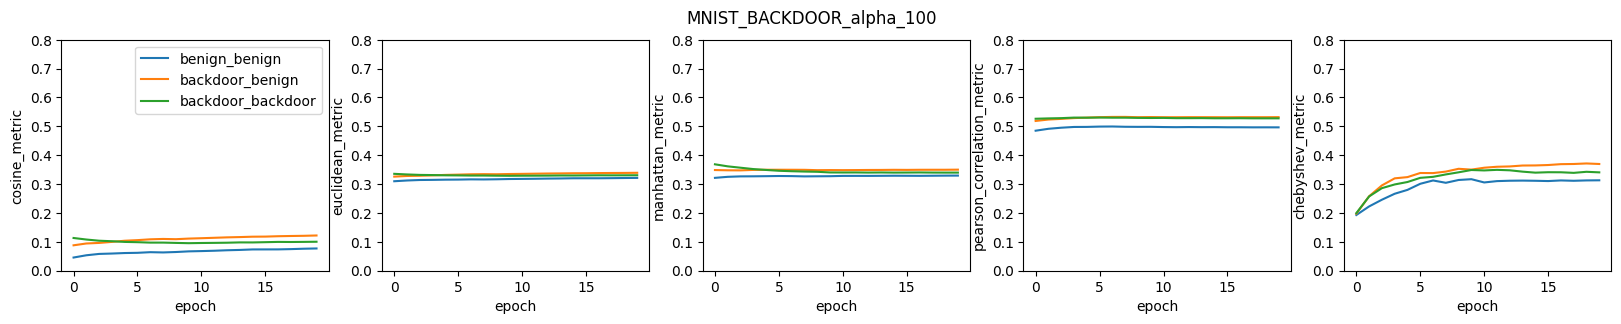

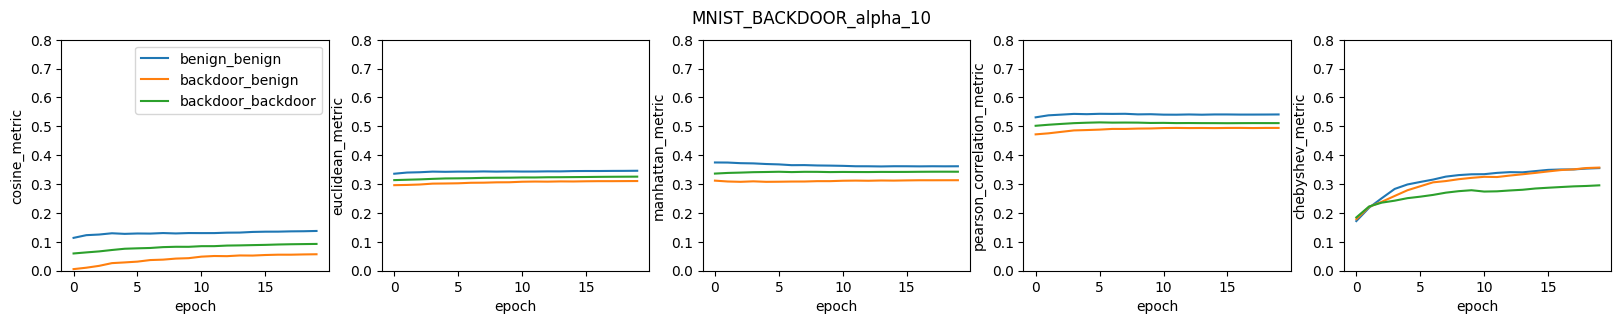

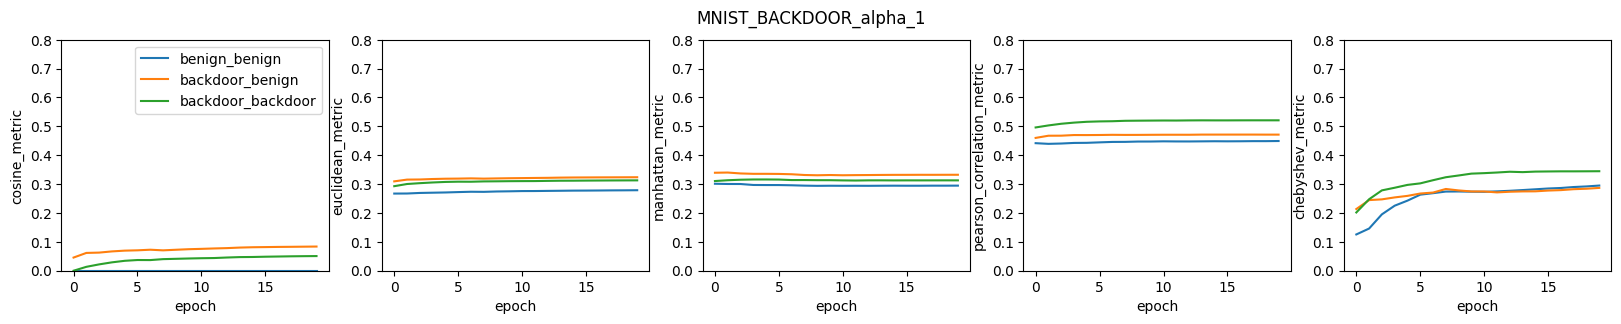

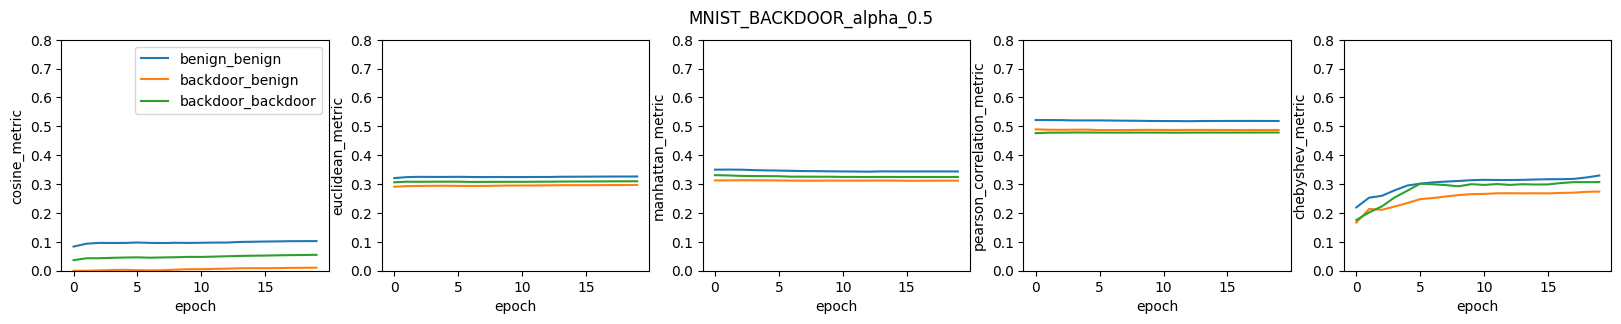

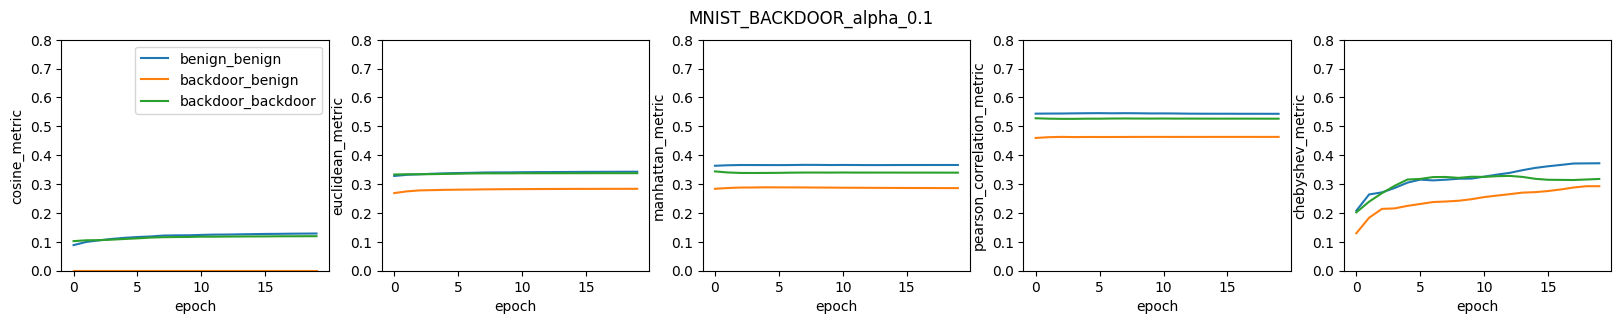

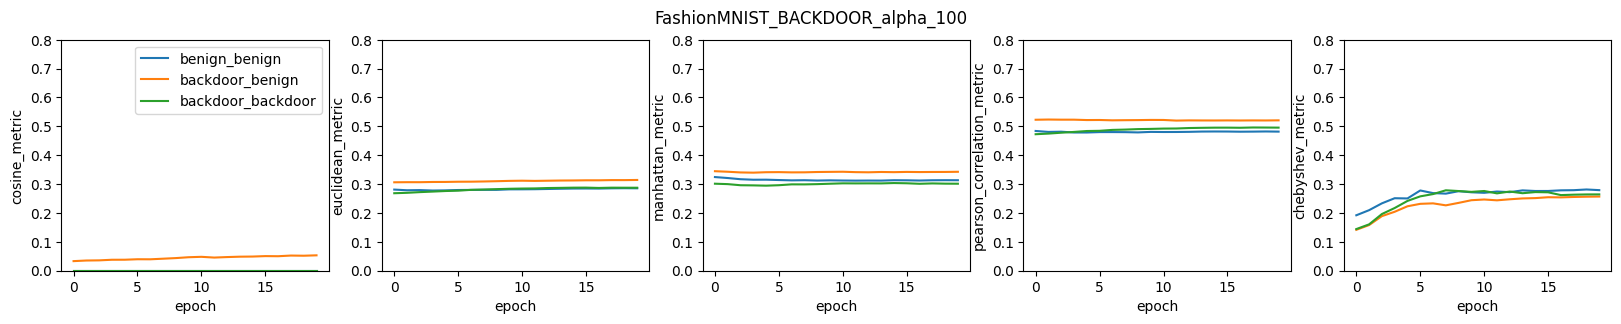

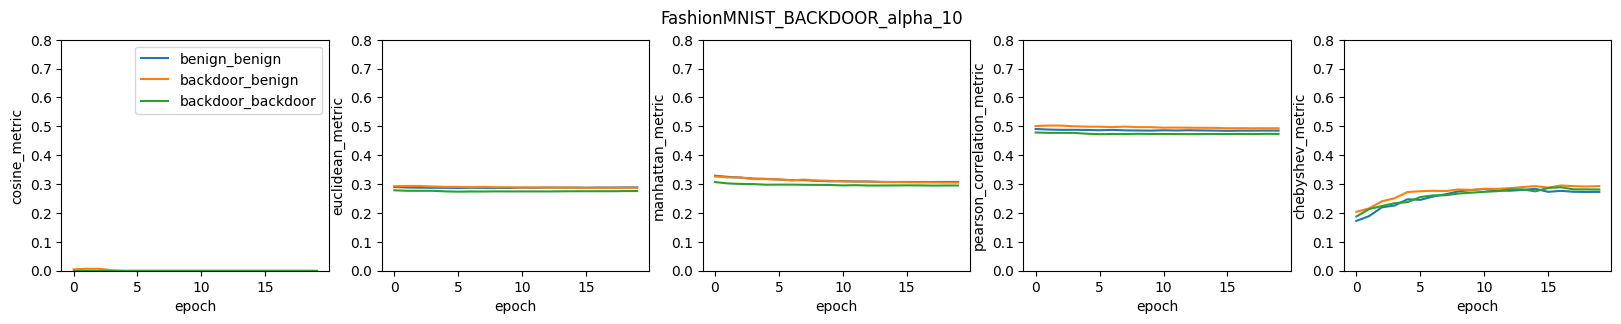

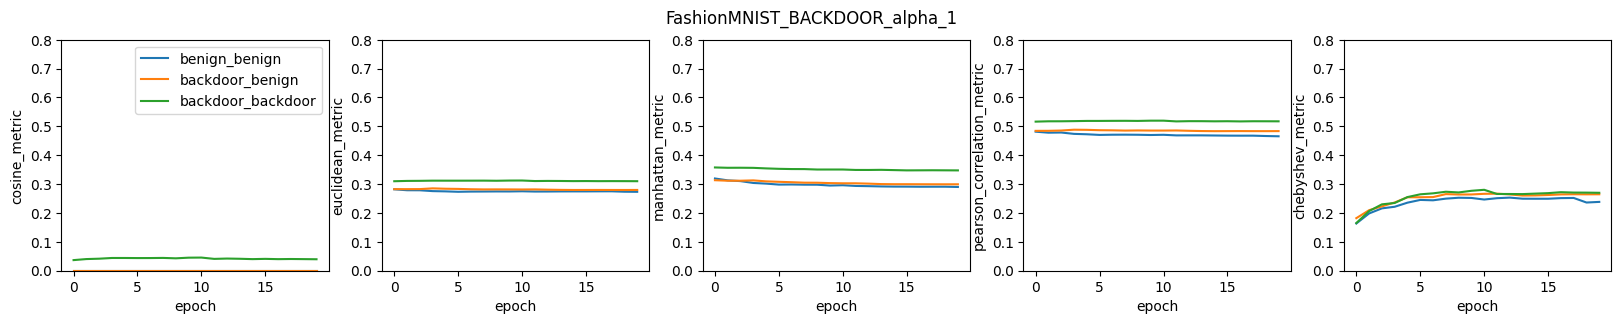

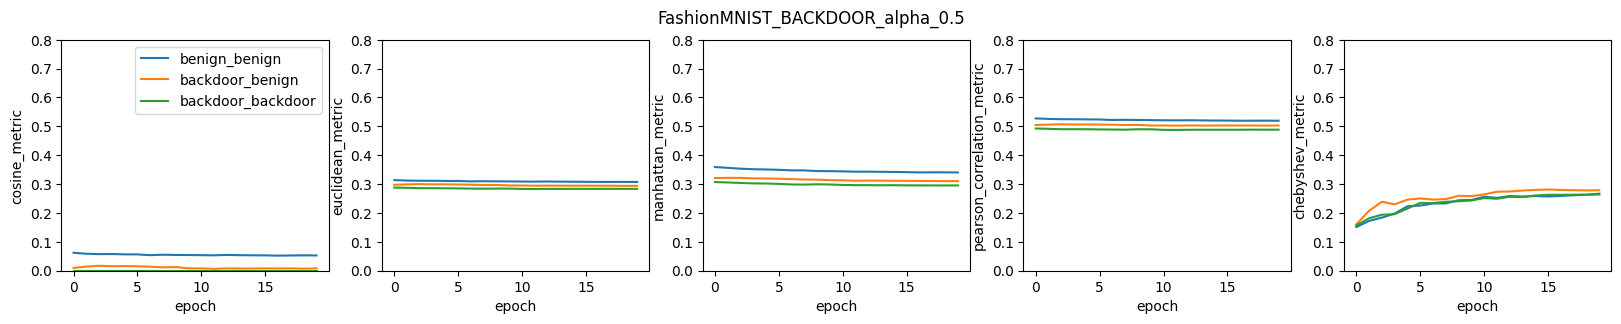

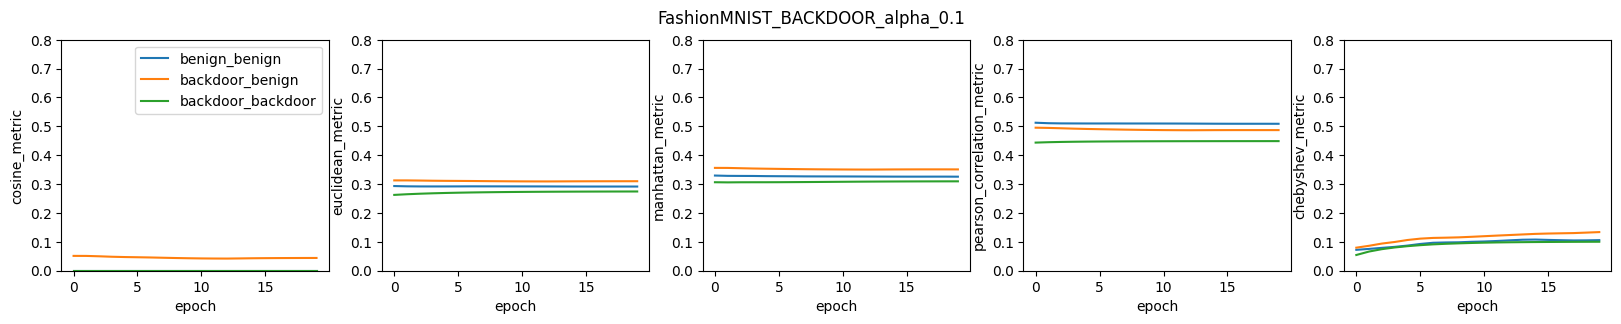

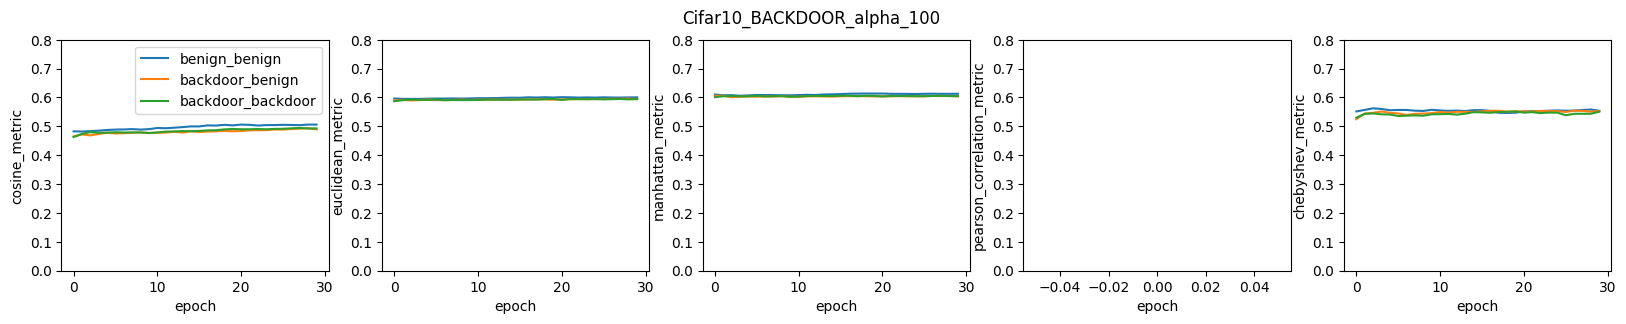

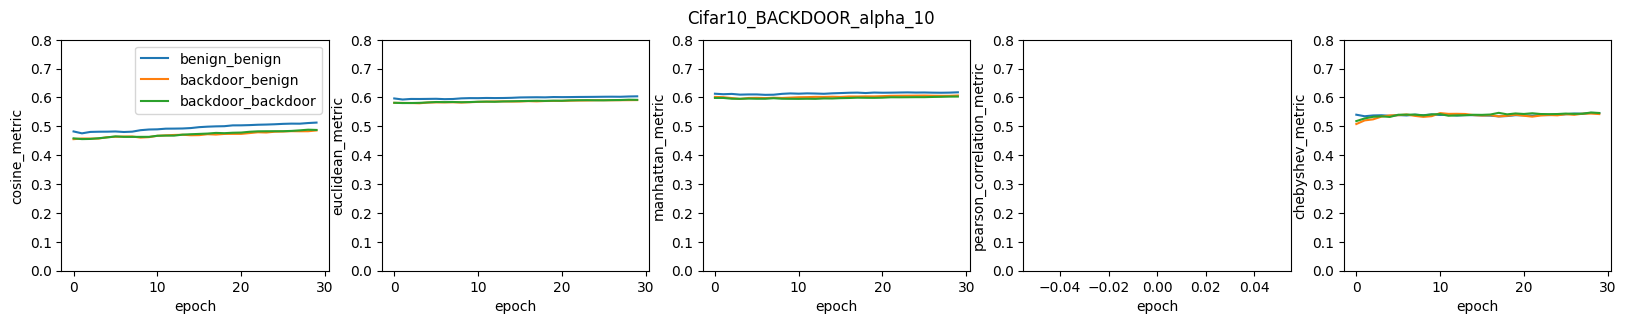

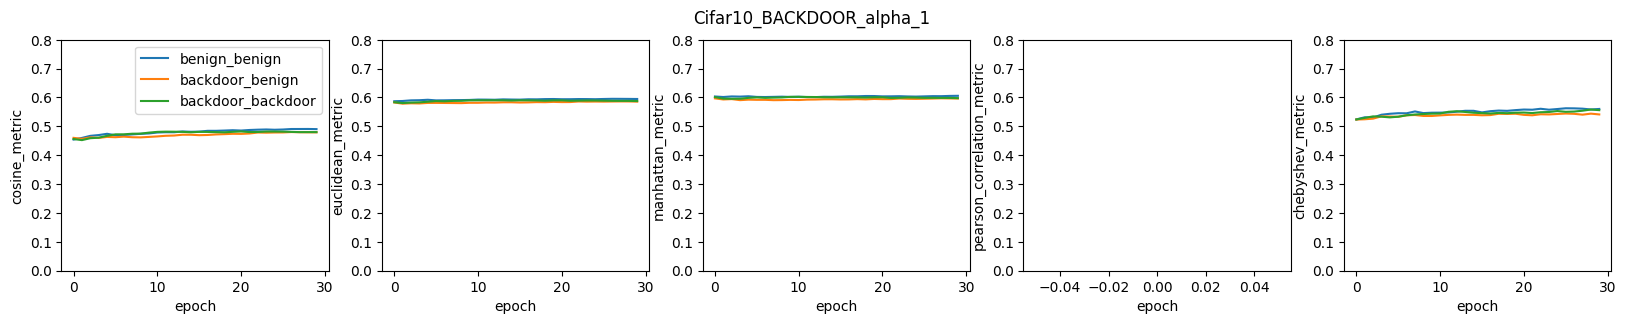

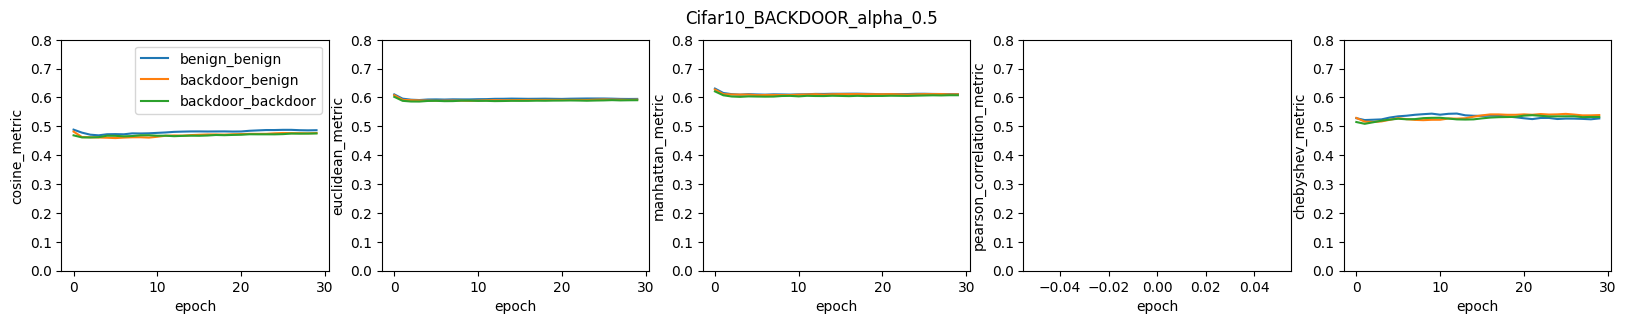

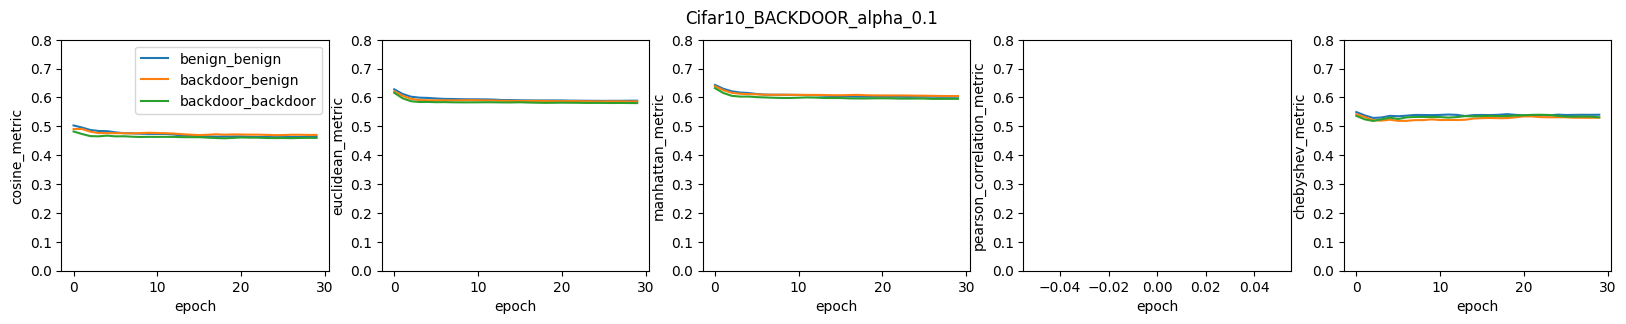

In [86]:
for dataset_name in ["MNIST", "FashionMNIST", "Cifar10"]:
    for alpha in [100, 10, 1, 0.5, 0.1]:
        if dataset_name == "Cifar10":
            maxEpoch = 30
        if dataset_name == "MNIST":
            maxEpoch = 20
        if dataset_name == "FashionMNIST":
            maxEpoch = 20

        cwd = os.getcwd()
        experimentsName=f'{dataset_name}_BACKDOOR_alpha_{alpha}'
        experimentsName_path = cwd+'/backdoor_experiments/'+experimentsName

        similarity_metrics = {
            'cosine_metric': {
                'benign_benign':[],
                'backdoor_benign':[],
                'backdoor_backdoor':[],

            },
            'euclidean_metric': {
                'benign_benign':[],
                'backdoor_benign':[],
                'backdoor_backdoor':[],
            },
            'manhattan_metric': {
                'benign_benign':[],
                'backdoor_benign':[],
                'backdoor_backdoor':[],
            },
            'pearson_correlation_metric': {
                'benign_benign':[],
                'backdoor_benign':[],
                'backdoor_backdoor':[],
            },
            'chebyshev_metric': {
                'benign_benign':[],
                'backdoor_benign':[],
                'backdoor_backdoor':[],
            },
        }

        for epoch in range(maxEpoch):

            checkpoint_name1 = f"{experimentsName_path}/node_0/{dataset_name}-epoch-epoch={epoch:02d}.ckpt"            
            checkpoint_name2 = f"{experimentsName_path}/node_1/{dataset_name}-epoch-epoch={epoch:02d}.ckpt"            
            checkpoint_name3 = f"{experimentsName_path}/node_2/{dataset_name}-epoch-epoch={epoch:02d}.ckpt"            
            checkpoint_name4 = f"{experimentsName_path}/node_3/{dataset_name}-epoch-epoch={epoch:02d}.ckpt"
            if dataset_name == "Cifar10":
                bm1 = SimpleMobileNet.load_from_checkpoint(checkpoint_name1)
                bm2 = SimpleMobileNet.load_from_checkpoint(checkpoint_name2)
                mm1 = SimpleMobileNet.load_from_checkpoint(checkpoint_name3)
                mm2 = SimpleMobileNet.load_from_checkpoint(checkpoint_name4)
            if dataset_name == "MNIST":
                bm1 = MNISTModelMLP.load_from_checkpoint(checkpoint_name1)
                bm2 = MNISTModelMLP.load_from_checkpoint(checkpoint_name2)
                mm1 = MNISTModelMLP.load_from_checkpoint(checkpoint_name3)
                mm2 = MNISTModelMLP.load_from_checkpoint(checkpoint_name4)
            if dataset_name == "FashionMNIST":
                bm1 = FashionMNISTModelMLP.load_from_checkpoint(checkpoint_name1)
                bm2 = FashionMNISTModelMLP.load_from_checkpoint(checkpoint_name2)
                mm1 = FashionMNISTModelMLP.load_from_checkpoint(checkpoint_name3)
                mm2 = FashionMNISTModelMLP.load_from_checkpoint(checkpoint_name4)
          
            similarity_metrics['cosine_metric']['benign_benign'].append(cosine_metric(bm1.state_dict(), bm2.state_dict()))
            similarity_metrics['cosine_metric']['backdoor_benign'].append(cosine_metric(mm1.state_dict(), bm1.state_dict()))
            similarity_metrics['cosine_metric']['backdoor_backdoor'].append(cosine_metric(mm1.state_dict(), mm2.state_dict()))
            similarity_metrics['cosine_metric']['epoch'] = list(range(maxEpoch))

            similarity_metrics['euclidean_metric']['benign_benign'].append(euclidean_metric(bm1.state_dict(), bm2.state_dict()))
            similarity_metrics['euclidean_metric']['backdoor_benign'].append(euclidean_metric(mm1.state_dict(), bm1.state_dict()))
            similarity_metrics['euclidean_metric']['backdoor_backdoor'].append(euclidean_metric(mm1.state_dict(), mm2.state_dict()))
            similarity_metrics['euclidean_metric']['epoch'] = list(range(maxEpoch))

            similarity_metrics['manhattan_metric']['benign_benign'].append(manhattan_metric(bm1.state_dict(), bm2.state_dict()))
            similarity_metrics['manhattan_metric']['backdoor_benign'].append(manhattan_metric(mm1.state_dict(), bm1.state_dict()))
            similarity_metrics['manhattan_metric']['backdoor_backdoor'].append(manhattan_metric(mm1.state_dict(), mm2.state_dict()))
            similarity_metrics['manhattan_metric']['epoch'] = list(range(maxEpoch))

            similarity_metrics['pearson_correlation_metric']['benign_benign'].append(pearson_correlation_metric(bm1.state_dict(), bm2.state_dict()))
            similarity_metrics['pearson_correlation_metric']['backdoor_benign'].append(pearson_correlation_metric(mm1.state_dict(), bm1.state_dict()))
            similarity_metrics['pearson_correlation_metric']['backdoor_backdoor'].append(pearson_correlation_metric(mm1.state_dict(), mm2.state_dict()))
            similarity_metrics['pearson_correlation_metric']['epoch'] = list(range(maxEpoch))

            similarity_metrics['chebyshev_metric']['benign_benign'].append(chebyshev_metric(bm1.state_dict(), bm2.state_dict()))
            similarity_metrics['chebyshev_metric']['backdoor_benign'].append(chebyshev_metric(mm1.state_dict(), bm1.state_dict()))
            similarity_metrics['chebyshev_metric']['backdoor_backdoor'].append(chebyshev_metric(mm1.state_dict(), mm2.state_dict()))
            similarity_metrics['chebyshev_metric']['epoch'] = list(range(maxEpoch))

        fig, axes = plt.subplots(1,5)
        fig.suptitle(f'{dataset_name}_BACKDOOR_alpha_{alpha}')
        for i,k in enumerate(list(similarity_metrics.keys())):
            df = pd.DataFrame(similarity_metrics[k])
            led = False
            if i == 0:
                led = True
            df.plot(x='epoch',xlabel='epoch', ylabel=k, ylim=(0,0.8), ax=axes[i], legend=led,figsize=(20,3),)
        experimentsName_path = experimentsName_path.replace('.','_')
        fig.savefig(experimentsName_path)


In [50]:
import matplotlib.pyplot as plt